# An independent check of Brachytherapy dose

Copyright (C) 2016-2017 Simon Biggs

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as
published by the Free Software Foundation, either version 3 of the
License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import dicom

from glob import glob
# import plotly.graph_objs as go
# from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode()

from scipy.interpolate import (
    splprep, splev, LinearNDInterpolator, interp1d, griddata, CloughTocher2DInterpolator,
    UnivariateSpline, NearestNDInterpolator, interp2d, SmoothBivariateSpline, Rbf
)

import pandas as pd

In [2]:
dose_filename = glob("private/RD1*")[0]
dose_filename

'private\\RD1.3.6.1.4.1.2452.6.1106550064.1084060564.1979941257.1777222634.dcm'

In [3]:
plan_filename = glob("private/RP1*")[0]
plan_filename

'private\\RP1.3.6.1.4.1.2452.6.3864298260.1122574174.3150967731.166011759.dcm'

## Dose information

In [4]:
dcm_dose = dicom.read_file(dose_filename, force=True)

def load_dose_from_dicom(dcm):
    pixels = np.transpose(
        dcm.pixel_array, (1, 2, 0))
    dose = pixels * dcm.DoseGridScaling
    
    return dose


def load_xyz_from_dicom(dcm):
    resolution = np.array(
        dcm.PixelSpacing).astype(float)
    dx = resolution[0]
    
    x = (
        dcm.ImagePositionPatient[0] + 
        np.arange(0, dcm.Columns * dx, dx))
    
    dy = resolution[1]
    y = (
        dcm.ImagePositionPatient[1] + 
        np.arange(0, dcm.Rows * dy, dy))
    
    z = (
        np.array(dcm.GridFrameOffsetVector) + 
        dcm.ImagePositionPatient[2])
    
    return x, y, z

## Dwell information

In [5]:
dcm_plan = dicom.read_file(plan_filename, force=True)

In [6]:
ref_airkerma_rate = np.float(dcm_plan.SourceSequence[0].ReferenceAirKermaRate)
ref_airkerma_rate

43939.3

In [7]:
dcm_plan.ApplicationSetupSequence[0].ChannelSequence[0]

(3006, 0084) Referenced ROI Number               IS: ''
(300a, 0110) Number of Control Points            IS: '26'
(300a, 0282) Channel Number                      IS: '1'
(300a, 0284) Channel Length                      DS: '1239.00000000000'
(300a, 0286) Channel Total Time                  DS: '22.0807651173517'
(300a, 0288) Source Movement Type                CS: 'STEPWISE'
(300a, 0290) Source Applicator Number            IS: '1'
(300a, 0291) Source Applicator ID                SH: '1'
(300a, 0292) Source Applicator Type              CS: 'FLEXIBLE'
(300a, 0294) Source Applicator Name              LO: ''
(300a, 0296) Source Applicator Length            DS: '158.898261747671'
(300a, 02a0) Source Applicator Step Size         DS: '2.50000000000000'
(300a, 02a2) Transfer Tube Number                IS: '1'
(300a, 02a4) Transfer Tube Length                DS: ''
(300a, 02c8) Final Cumulative Time Weight        DS: '5.07299481332302'
(300a, 02d0)  Brachy Control Point Sequence   26 item(s) -

In [8]:
dcm_plan.ApplicationSetupSequence[0].ChannelSequence[0].BrachyControlPointSequence[4].CumulativeTimeWeight

'1.83374685049057'

In [9]:
dcm_plan.ApplicationSetupSequence[0].ChannelSequence[0].ChannelTotalTime

'22.0807651173517'

In [10]:
dcm_plan.ApplicationSetupSequence[0].ChannelSequence[0].FinalCumulativeTimeWeight

'5.07299481332302'

http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.8.8.15.6.html

 > The treatment time at a given Control Point is equal to the Channel Total Time (300A,0286), multiplied by the Cumulative Time Weight (300A,02D6) for the Control Point, divided by the Final Cumulative Time Weight (300A,02C8). If the calculation for treatment time results in a time value that is not an exact multiple of the timer resolution, then the result shall be rounded to the nearest allowed timer value (i.e., less than a half resolution unit shall be rounded down to the nearest resolution unit, and equal or greater than half a resolution unit shall be rounded up to the nearest resolution unit).

In [11]:
channel_time_weight = (
    dcm_plan.ApplicationSetupSequence[0].ChannelSequence[0].ChannelTotalTime /
    dcm_plan.ApplicationSetupSequence[0].ChannelSequence[0].FinalCumulativeTimeWeight
)

dwell_time = (
    dcm_plan.ApplicationSetupSequence[0].ChannelSequence[0].BrachyControlPointSequence[4].CumulativeTimeWeight *
    channel_time_weight
)
dwell_time

7.981583853393053

In [12]:
dwell_time = (
    dcm_plan.ApplicationSetupSequence[0].ChannelSequence[0].ChannelTotalTime *
    dcm_plan.ApplicationSetupSequence[0].ChannelSequence[0].BrachyControlPointSequence[4].CumulativeTimeWeight /
    dcm_plan.ApplicationSetupSequence[0].ChannelSequence[0].FinalCumulativeTimeWeight    
)
dwell_time

7.981583853393053

In [13]:
def pull_dwells(dcm):
    dwell_channels = []
    all_dwell_positions = []
    dwell_times = []

    number_of_channels = len(dcm.ApplicationSetupSequence[0].ChannelSequence)

    for i in range(number_of_channels):
        ChannelSequence = dcm.ApplicationSetupSequence[0].ChannelSequence[i]

        if len(ChannelSequence.dir("FinalCumulativeTimeWeight")) != 0:

            BrachyControlPointSequence = (
                ChannelSequence.BrachyControlPointSequence)
            number_of_dwells_in_channel = len(BrachyControlPointSequence)//2

            channel_time_weight = (
                    ChannelSequence.ChannelTotalTime / ChannelSequence.FinalCumulativeTimeWeight)

            channel_dwells_positions = []
            for j in range(0,number_of_dwells_in_channel*2,2):
                if len(BrachyControlPointSequence[j].dir("ControlPoint3DPosition")) != 0:
                    channel_dwells_positions.append(
                        BrachyControlPointSequence[j].ControlPoint3DPosition)
                    dwell_channels.append(i+1)

                    assert (
                        BrachyControlPointSequence[j].ControlPoint3DPosition == 
                        BrachyControlPointSequence[j+1].ControlPoint3DPosition
                    )
                    uncorrected_dwell_time = (
                        BrachyControlPointSequence[j+1].CumulativeTimeWeight - 
                        BrachyControlPointSequence[j].CumulativeTimeWeight
                    )
                    dwell_times.append(
                        uncorrected_dwell_time * channel_time_weight)

            all_dwell_positions += channel_dwells_positions

    dwell_channels = np.array(dwell_channels)
    dwell_positions = np.array(all_dwell_positions).astype(float)
    dwell_times = np.array(dwell_times)
    
    return dwell_positions, dwell_channels, dwell_times

dwell_positions, dwell_channels, dwell_times = pull_dwells(dcm_plan)

In [14]:
dwell_positions

array([[-21.196375,   8.158049,  36.385686],
       [-20.892436,   8.876451,  34.010497],
       [-20.588497,   9.594852,  31.635308],
       [-20.293912,  10.336907,  29.266542],
       [-20.020003,  11.131245,  26.911972],
       [-19.746093,  11.925583,  24.557402],
       [-19.465747,  12.727309,  22.206254],
       [-19.140841,  13.580187,  19.878802],
       [-18.815936,  14.433065,  17.551349],
       [-18.545826,  15.345881,  15.239715],
       [-18.276953,  16.26005 ,  12.928438],
       [-18.00808 ,  17.174219,  10.617161],
       [-17.523745,  19.171616,   6.059713],
       [-10.954297,   7.929537,  36.402452],
       [-10.76197 ,   8.726318,  34.040641],
       [-10.569644,   9.523098,  31.67883 ],
       [-10.38579 ,  10.342869,  29.324566],
       [-10.22276 ,  11.219152,  26.988854],
       [-10.059731,  12.095435,  24.653143],
       [ -9.896702,  12.971718,  22.317431],
       [ -9.733683,  13.848416,  19.981879],
       [ -9.572081,  14.777629,  17.666615],
       [ -

In [15]:
dwell_channels

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16])

In [16]:
dwell_times

array([ 4.4441446 ,  3.53743926,  0.54528554,  0.83747958,  1.2643842 ,
        0.88938139,  0.6651014 ,  3.11030426,  0.14138572,  1.54951511,
        0.51383554,  0.22292494,  4.35958359,  1.43336884,  1.34698945,
        1.11360184,  1.18099274,  0.21455738,  0.58685331,  0.58776146,
        0.28970644,  0.8803372 ,  0.35951998,  0.36325476,  0.29862049,
        1.04852439,  0.38111431,  1.84388452,  1.71121972,  1.78205385,
        0.22289336,  0.59284031,  0.74100127,  0.51868456,  0.81555428,
        0.29663733,  1.26089843,  0.29709725,  0.22349213,  1.04000355,
        1.63372315,  1.97241404,  1.11680094,  0.44608613,  0.74063572,
        0.36930412,  1.48212317,  1.85360843,  1.14979274,  0.59440003,
        1.18886752,  0.67172401,  0.30406326,  2.78795872,  1.39861483,
        0.66215803,  0.        ,  0.05953608,  0.16012504,  0.23015739,
        0.17933705,  0.0966381 ,  0.        ,  0.        ,  0.22002774,
        0.62648276,  1.36702671,  1.84216005,  3.03128169,  1.81

In [17]:
def pull_catheter_coords(dcm, channel):
    index = channel - 1
    catheter_coords = dcm[0x300f,0x1000][0].ROIContourSequence[index].ContourSequence[0].ContourData
    
    x = np.array(catheter_coords[0::3])
    y = np.array(catheter_coords[1::3])
    z = np.array(catheter_coords[2::3])
    
    return x, y, z

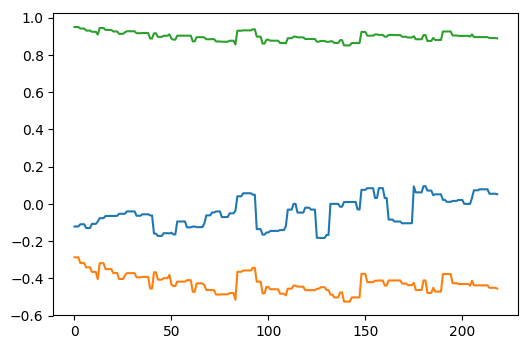

In [18]:
def determine_single_dwell_direction(dwell_position, dwell_channel):
    x, y, z = pull_catheter_coords(dcm_plan, dwell_channel)
#     tckp, u = splprep([x,y,z], s=1, k=2, nest=-1)
    tckp, u = splprep([x,y,z], s=0, k=1, nest=-1)  # Linear interp

    t = np.linspace(0,1,1000)
    x_spline, y_spline, z_spline = splev(t, tckp)    
    t_z = interp1d(z_spline, t)(dwell_position[2])
    
    derivative_vector = np.array(splev(t_z, tckp, der=1))
    forward_direction = derivative_vector / np.linalg.norm(derivative_vector)
    
    return forward_direction

def determine_dwell_directions(dwell_positions, dwell_channels):
    dwell_directions = np.array([
        determine_single_dwell_direction(dwell_positions[i], dwell_channels[i])
        for i in range(len(dwell_positions))
    ])
    
    return dwell_directions

dwell_directions = determine_dwell_directions(dwell_positions, dwell_channels)

plt.plot(dwell_directions)

## TG 43 implementation

In [19]:
def calculate_beta(length, radius, theta):
    # http://jacmp.org/index.php/jacmp/article/viewFile/2615/1083
    theta2 = np.arctan(
        radius * np.sin(theta) / 
        (radius * np.cos(theta) - length/2))
    
    AP = radius * np.sin(theta)
    SA = radius * np.cos(theta) + length/2
    
    SP = np.sqrt(AP**2 + SA**2)
    
    beta = np.arcsin(
        length * np.sin(theta2) / 
        SP)
    
    return beta


def geometry_function(length, radius, theta):
    theta = theta / 180 * np.pi
    result = np.empty_like(radius)
    
    ref0 = (theta == 0) | (theta == np.pi)
    ref1 = (theta != 0) & (theta != np.pi)
    
    result[ref0] = (
        1 / (radius[ref0]**2 - length**2 / 4))
    
    beta = calculate_beta(
        length, radius[ref1], theta[ref1])
    result[ref1] = (
        beta / (length * radius[ref1] * np.sin(theta[ref1])))   
        
    return np.abs(result)


def normalised_geometry_function(length, radius, theta):
    return (        
        geometry_function(length, radius, theta) / 
        np.abs(calculate_beta(length, 1, np.pi/2) / length))

In [20]:
# radial_dose_function_radius = np.array([
#     0.10, 0.20, 0.30, 0.50, 1.00, 1.50, 
#     2.00, 2.50, 3.00, 4.00, 5.00, 6.00, 
#     7.00, 8.00, 9.00, 10.00, 11.00, 
#     12.00, 13.00, 14.00])

# radial_dose_function_data = [
#     1.004, 1.000, 1.001, 1.000, 1.000, 
#     1.003, 1.007, 1.008, 1.008, 1.004, 
#     0.995, 0.981, 0.964, 0.940, 0.913, 
#     0.882, 0.844, 0.799, 0.747, 0.681]

# radial_dose_function_uncorr = UnivariateSpline(
#     np.sqrt(radial_dose_function_radius), radial_dose_function_data, s=1)

# def radial_dose_function(radius):
#     return radial_dose_function_uncorr(np.sqrt(radius))


# x_test = np.linspace(0, 20, 300)
# plt.plot(x_test, radial_dose_function(x_test))
# plt.plot(radial_dose_function_radius, radial_dose_function_data, 'x')

# plt.show()

# plt.plot(x_test, radial_dose_function(x_test))
# plt.plot(radial_dose_function_radius, radial_dose_function_data, 'x')

# plt.xlim([0,7])
# plt.ylim([0.99, 1.01])

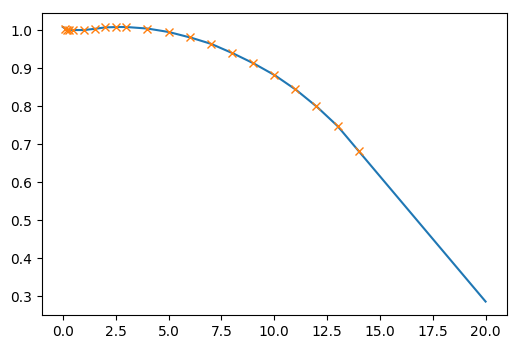

(0.99, 1.01)

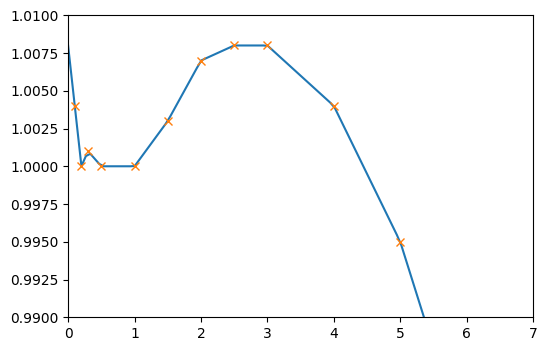

In [21]:
radial_dose_function_radius = np.array([
    0.10, 0.20, 0.30, 0.50, 1.00, 1.50, 
    2.00, 2.50, 3.00, 4.00, 5.00, 6.00, 
    7.00, 8.00, 9.00, 10.00, 11.00, 
    12.00, 13.00, 14.00])

radial_dose_function_data = np.array([
    1.004, 1.000, 1.001, 1.000, 1.000, 
    1.003, 1.007, 1.008, 1.008, 1.004, 
    0.995, 0.981, 0.964, 0.940, 0.913, 
    0.882, 0.844, 0.799, 0.747, 0.681])

radial_dose_function = UnivariateSpline(radial_dose_function_radius, radial_dose_function_data, s=0, k=1)

x_test = np.linspace(0, 20, 300)
plt.plot(x_test, radial_dose_function(x_test))
plt.plot(radial_dose_function_radius, radial_dose_function_data, 'x')

plt.show()

x_test = np.linspace(0, 20, 300)
plt.plot(x_test, radial_dose_function(x_test))
plt.plot(radial_dose_function_radius, radial_dose_function_data, 'x')

plt.xlim([0,7])
plt.ylim([0.99, 1.01])

In [22]:
length = 0.36
dose_rate_constant = 1.108

dose_table_x = np.array([
    0.00, 0.10, 0.15, 0.25, 0.35, 0.50, 0.75, 
    1.00, 1.50, 2.00, 2.50, 3.00, 5.00, 7.00])
dose_table_y = np.array([
    7.00, 6.00, 5.00, 4.00, 3.00, 2.50, 2.00, 1.50, 
    1.00, 0.75, 0.50, 0.25, 0.10, 0.00, -0.10, -0.25, 
    -0.50, -0.75, -1.00, -1.50, -2.00, -2.50, -3.00, 
    -4.00, -5.00, -6.00, -7.00])

dose_table = np.array([
    [0.0164, 0.0163, 0.0163, 0.0164, 0.0165, 0.0167, 0.0170, 0.0169, 0.0173, 0.0172, 0.0169, 0.0164, 0.0132, 0.0097],
    [0.0223, 0.0222, 0.0223, 0.0225, 0.0226, 0.023, 0.0234, 0.0233, 0.0238, 0.0236, 0.0228, 0.0219, 0.0165, 0.0116],
    [0.0318, 0.0319, 0.032, 0.0324, 0.0326, 0.0333, 0.034, 0.0341, 0.0345, 0.0336, 0.0319, 0.0299, 0.0208, 0.0137],
    [0.0483, 0.0486, 0.0488, 0.0496, 0.0502, 0.0524, 0.053, 0.0538, 0.0533, 0.0504, 0.0463, 0.0419, 0.0259, 0.0159],
    [0.0840, 0.0852, 0.0859, 0.0879, 0.0897, 0.0926, 0.0952, 0.095, 0.0899, 0.0803, 0.0698, 0.0598, 0.0319, 0.0182],
    [0.119, 0.122, 0.122, 0.127, 0.130, 0.134, 0.137, 0.134, 0.122, 0.104, 0.0864, 0.0713, 0.0349, 0.0192],
    [0.183, 0.190, 0.190, 0.198, 0.206, 0.212, 0.212, 0.201, 0.169, 0.135, 0.107, 0.0846, 0.0379, 0.0201],
    [0.324, 0.334, 0.343, 0.360, 0.372, 0.377, 0.358, 0.320, 0.239, 0.176, 0.130, 0.0985, 0.0406, 0.0209],
    [0.745, 0.781, 0.809, 0.849, 0.854, 0.810, 0.677, 0.540, 0.339, 0.223, 0.154, 0.112, 0.0427, 0.0215],
    [1.357, 1.440, 1.500, 1.539, 1.479, 1.301, 0.963, 0.701, 0.394, 0.246, 0.165, 0.117, 0.0435, 0.0217],
    [3.405, 3.631, 3.691, 3.408, 2.907, 2.185, 1.351, 0.884, 0.446, 0.265, 0.173, 0.121, 0.0441, 0.0219],
    [np.nan, 19.71, 15.12, 9.177, 5.968, 3.507, 1.760, 1.042, 0.483, 0.278, 0.178, 0.124, 0.0445, 0.0219],
    [np.nan, 58.79, 32.18, 14.19, 7.944, 4.154, 1.917, 1.096, 0.495, 0.282, 0.180, 0.125, 0.0446, 0.0220],
    [np.nan, 66.36, 36.36, 15.52, 8.434, 4.299, 1.950, 1.108, 0.497, 0.282, 0.180, 0.125, 0.0446, 0.0220],
    [np.nan, 58.79, 32.23, 14.20, 7.952, 4.151, 1.918, 1.097, 0.495, 0.282, 0.180, 0.125, 0.0446, 0.0220],
    [np.nan, 19.68, 15.14, 9.182, 5.976, 3.501, 1.761, 1.042, 0.483, 0.278, 0.178, 0.124, 0.0445, 0.0219],
    [3.127, 3.559, 3.655, 3.402, 2.909, 2.179, 1.350, 0.883, 0.446, 0.265, 0.173, 0.121, 0.0441, 0.0219],
    [1.242, 1.379, 1.467, 1.527, 1.476, 1.298, 0.963, 0.701, 0.394, 0.246, 0.165, 0.117, 0.0435, 0.0217],
    [0.668, 0.739, 0.783, 0.837, 0.848, 0.806, 0.677, 0.539, 0.339, 0.223, 0.154, 0.112, 0.0427, 0.0215],
    [0.301, 0.314, 0.327, 0.350, 0.366, 0.373, 0.357, 0.321, 0.240, 0.176, 0.130, 0.0987, 0.0406, 0.0209],
    [0.170, 0.179, 0.180, 0.190, 0.202, 0.210, 0.211, 0.200, 0.169, 0.135, 0.107, 0.0847, 0.0379, 0.0201],
    [0.112, 0.115, 0.115, 0.122, 0.127, 0.132, 0.136, 0.134, 0.121, 0.104, 0.0861, 0.0714, 0.0349, 0.0192],
    [0.0790, 0.0803, 0.0814, 0.0840, 0.0869, 0.0904, 0.094, 0.0943, 0.0896, 0.0802, 0.0695, 0.0597, 0.0319, 0.0182],
    [0.0455, 0.0470, 0.0466, 0.0473, 0.0494, 0.0509, 0.0528, 0.0532, 0.0529, 0.0502, 0.0461, 0.0418, 0.0259, 0.0159],
    [0.0303, 0.0305, 0.0307, 0.0311, 0.0316, 0.0322, 0.0333, 0.0334, 0.0342, 0.0344, 0.0318, 0.0298, 0.0207, 0.0137],
    [0.0212, 0.0213, 0.0214, 0.0216, 0.0219, 0.0222, 0.0228, 0.0229, 0.0236, 0.0234, 0.0228, 0.0217, 0.0165, 0.0116],
    [0.0156, 0.0156, 0.0157, 0.0158, 0.0160, 0.0162, 0.0165, 0.0166, 0.0171, 0.0171, 0.0168, 0.0163, 0.0132, 0.0097]])

dose_table_radius = np.sqrt(dose_table_x[None,:]**2 + dose_table_y[:,None]**2)

dot_product = dose_table_y[:,None] / dose_table_radius

dose_table_theta = np.arccos(dot_product) * 180 / np.pi
nan_ref = np.isnan(dose_table_theta)

dose_table_theta[nan_ref] = 90

initial_shape = np.shape(dose_table_radius)
radius_flat = np.ravel(dose_table_radius)
theta_flat = np.ravel(dose_table_theta)

geometry = normalised_geometry_function(length, radius_flat, theta_flat)
radial_dose = radial_dose_function(radius_flat)

combined_flat = dose_rate_constant * geometry * radial_dose
combined = np.reshape(combined_flat, initial_shape)

dose_table_anisotropy = dose_table / combined

dose_table_anisotropy


ref = np.invert(np.isnan(dose_table_anisotropy))
dose_table_anisotropy_flat = dose_table_anisotropy[ref]
dose_table_theta_flat = dose_table_theta[ref]
dose_table_radius_flat = dose_table_radius[ref]

C:\Users\sbiggs\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:44: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sbiggs\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: RuntimeWarning: invalid value encountered in true_divide


In [23]:
pd.DataFrame(dose_table_anisotropy)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.743892,0.739521,0.739726,0.744925,0.750466,0.761709,0.780752,0.783627,0.824063,0.849889,0.873912,0.894430,0.944033,0.958924
1,0.730099,0.727038,0.730580,0.737995,0.742575,0.758531,0.778738,0.785199,0.830666,0.863539,0.883973,0.907728,0.951299,0.971520
2,0.712550,0.715087,0.717701,0.727879,0.734192,0.753909,0.779652,0.795849,0.845444,0.878441,0.901453,0.922574,0.964864,0.979977
3,0.685942,0.690644,0.694040,0.707218,0.718508,0.756062,0.779762,0.812921,0.865977,0.899264,0.921333,0.939448,0.973261,0.983548
4,0.667313,0.677609,0.684137,0.703214,0.722434,0.756361,0.804236,0.839763,0.895322,0.925635,0.945461,0.958870,0.984874,0.993109
5,0.655456,0.673069,0.674429,0.706600,0.730248,0.767952,0.823304,0.857494,0.916393,0.943672,0.957959,0.966273,0.987048,0.993448
6,0.643849,0.670177,0.672301,0.707693,0.747338,0.793262,0.852403,0.886549,0.933194,0.955461,0.971792,0.976450,0.991930,0.993872
7,0.639678,0.662435,0.684153,0.731044,0.775515,0.829158,0.887614,0.918270,0.951205,0.973732,0.978825,0.983235,0.996246,0.996310
8,0.643705,0.682071,0.715917,0.782785,0.834693,0.886443,0.933125,0.956895,0.977791,0.988705,0.989745,0.993467,0.998092,0.997749
9,0.642351,0.695525,0.742529,0.820618,0.872491,0.922141,0.958029,0.973753,0.985943,0.996203,0.996840,0.992351,0.999110,0.997457


(-1, 1)

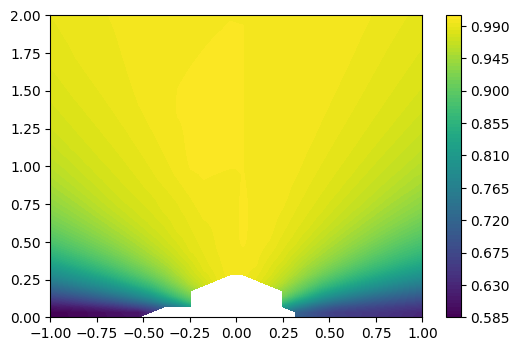

In [24]:
# http://www.estro.org/binaries/content/assets/estro/about/gec-estro/tg43-sources/192ir-hdr_nucletron-mhdr-v2.xls
anisotropy_radius = [0.25, 0.5, 1, 2, 3, 5]
anisotropy_theta = [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 16, 
    20, 24, 30, 36, 42, 48, 58, 73, 88, 90, 103, 
    118, 128, 133, 138, 143, 148, 153, 158, 165, 
    169, 170, 172, 173, 174, 175, 176, 177, 178, 
    179, 180]

anisotropy_radius_mesh, anisotropy_theta_mesh = np.meshgrid(
    anisotropy_radius, anisotropy_theta)

raw_anisotropy_data = np.array(
    [[0.729, 0.667, 0.631, 0.645, 0.660, 0.696],
    [0.730, 0.662, 0.631, 0.645, 0.661, 0.701],
    [0.729, 0.662, 0.632, 0.652, 0.670, 0.709],
    [0.730, 0.663, 0.640, 0.662, 0.679, 0.718],
    [0.731, 0.664, 0.650, 0.673, 0.690, 0.726],
    [0.733, 0.671, 0.661, 0.684, 0.700, 0.735],
    [0.735, 0.680, 0.674, 0.696, 0.711, 0.743],
    [0.734, 0.691, 0.687, 0.708, 0.723, 0.753],
    [0.739, 0.702, 0.700, 0.720, 0.734, 0.763],
    [0.756, 0.727, 0.727, 0.745, 0.758, 0.782],
    [0.777, 0.751, 0.753, 0.769, 0.781, 0.804],
    [0.802, 0.775, 0.778, 0.791, 0.802, 0.822],
    [0.820, 0.797, 0.800, 0.812, 0.822, 0.840],
    [0.856, 0.836, 0.839, 0.846, 0.854, 0.872],
    [0.885, 0.868, 0.869, 0.874, 0.877, 0.888],
    [0.920, 0.904, 0.902, 0.907, 0.906, 0.911],
    [0.938, 0.930, 0.929, 0.931, 0.934, 0.933],
    [0.957, 0.949, 0.949, 0.955, 0.956, 0.954],
    [0.967, 0.963, 0.965, 0.965, 0.969, 0.965],
    [0.982, 0.982, 0.982, 0.982, 0.983, 0.978],
    [0.994, 0.997, 0.997, 0.998, 0.996, 0.985],
    [0.997, 1.001, 1.000, 1.000, 1.000, 1.001],
    [1.000, 1.000, 1.000, 1.000, 1.000, 1.000],
    [0.995, 0.995, 1.001, 0.999, 1.000, 0.995],
    [0.987, 0.987, 0.987, 0.989, 0.989, 0.983],
    [0.974, 0.972, 0.976, 0.976, 0.980, 0.979],
    [0.969, 0.961, 0.966, 0.965, 0.973, 0.973],
    [0.957, 0.949, 0.952, 0.952, 0.959, 0.960],
    [0.942, 0.933, 0.935, 0.935, 0.944, 0.941],
    [0.924, 0.912, 0.914, 0.915, 0.924, 0.926],
    [0.899, 0.886, 0.887, 0.889, 0.899, 0.905],
    [0.873, 0.850, 0.850, 0.856, 0.863, 0.870],
    [0.806, 0.779, 0.778, 0.791, 0.801, 0.816],
    [np.nan, 0.725, 0.723, 0.741, 0.754, 0.785],
    [np.nan, 0.710, 0.707, 0.727, 0.742, 0.774],
    [np.nan, 0.678, 0.675, 0.697, 0.714, 0.748],
    [np.nan, 0.662, 0.657, 0.682, 0.700, 0.733],
    [np.nan, 0.642, 0.640, 0.667, 0.686, 0.720],
    [np.nan, 0.623, 0.624, 0.652, 0.672, 0.707],
    [np.nan, 0.605, 0.608, 0.637, 0.658, 0.695],
    [np.nan, 0.606, 0.594, 0.624, 0.645, 0.686],
    [np.nan, 0.608, 0.586, 0.612, 0.634, 0.675],
    [np.nan, 0.609, 0.585, 0.604, 0.624, 0.665],
    [np.nan, 0.609, 0.585, 0.603, 0.622, 0.662]])



assert np.shape(anisotropy_radius_mesh) == np.shape(raw_anisotropy_data)




ref = np.invert(np.isnan(raw_anisotropy_data))
anisotropy_radius_flat = anisotropy_radius_mesh[ref]
anisotropy_theta_flat = anisotropy_theta_mesh[ref]
anisotropy_data_flat = raw_anisotropy_data[ref]

# anisotropy_radius_combined = np.append(anisotropy_radius_flat, dose_table_radius_flat)
# anisotropy_theta_combined = np.append(anisotropy_theta_flat, dose_table_theta_flat)
# anisotropy_data_combined = np.append(anisotropy_data_flat, dose_table_anisotropy_flat)

anisotropy_radius_combined = anisotropy_radius_flat
anisotropy_theta_combined = anisotropy_theta_flat
anisotropy_data_combined = anisotropy_data_flat


points = np.array([
    [anisotropy_radius_combined[i], anisotropy_theta_combined[i]]
    for i in range(len(anisotropy_radius_combined))])

values = anisotropy_data_combined

anisotropy_function = LinearNDInterpolator(
    points, values, fill_value=np.nan)


x = np.linspace(0,7,200)
y = np.linspace(7,-7,200)
x, y = np.meshgrid(x, y)

radius = np.sqrt(x**2 + y**2)
theta = np.arctan2(x, y) * 180 / np.pi
# fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
c = plt.contourf(
    y, x, anisotropy_function((radius, theta)), 
    100, cmap="viridis")

plt.colorbar(c)
plt.ylim([0,2])
plt.xlim([-1,1])


In [25]:
emulated_dose_table_anisotropy = anisotropy_function((dose_table_radius, dose_table_theta))
pd.DataFrame(emulated_dose_table_anisotropy)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.6960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.6780,0.684914,0.690883,0.704751,0.717775,0.739717,0.777962,0.813557,0.868645,0.894929,0.918495,0.936045,NaN,NaN
4,0.6600,0.669216,0.677835,0.697818,0.719158,0.752148,0.803249,0.842940,0.890283,0.924734,0.947049,0.961015,NaN,NaN
5,0.6525,0.663651,0.675346,0.700214,0.726977,0.767313,0.824044,0.861899,0.910582,0.943551,0.961964,0.970262,NaN,NaN
6,0.6450,0.660667,0.676276,0.709718,0.744504,0.792058,0.850300,0.888816,0.935980,0.962328,0.973273,0.979289,NaN,NaN
7,0.6380,0.659717,0.681402,0.729651,0.775498,0.827809,0.886493,0.920774,0.960485,0.974221,0.984021,0.985763,NaN,NaN
8,0.6310,0.670347,0.707389,0.778799,0.832494,0.883698,0.932400,0.957000,0.979127,0.988033,0.992454,0.993864,NaN,NaN
9,0.6490,0.695704,0.743089,0.822484,0.874757,0.919000,0.957000,0.973721,0.987797,0.994343,0.996820,0.996283,NaN,NaN


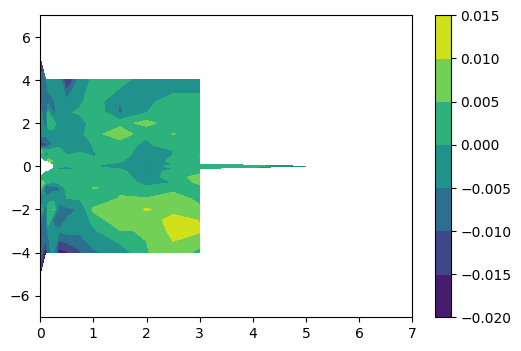

In [26]:
plt.contourf(dose_table_x, dose_table_y, emulated_dose_table_anisotropy - dose_table_anisotropy)
plt.colorbar()


In [27]:
np.nanmax(np.abs(emulated_dose_table_anisotropy - dose_table_anisotropy))

0.01905999966015659

(-1, 1)

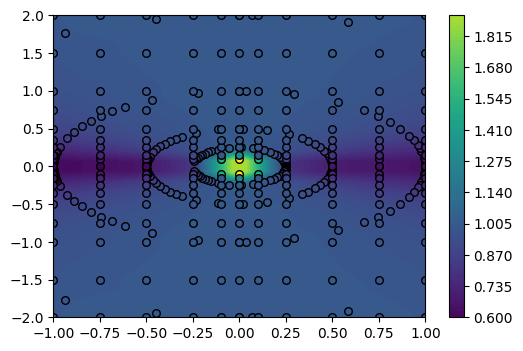

In [84]:
anisotropy_radius_combined = np.append(anisotropy_radius_flat, dose_table_radius_flat)
anisotropy_theta_combined = np.append(anisotropy_theta_flat, dose_table_theta_flat)
anisotropy_data_combined = np.append(anisotropy_data_flat, dose_table_anisotropy_flat)

# anisotropy_radius_combined = anisotropy_radius_flat
# anisotropy_theta_combined = anisotropy_theta_flat
# anisotropy_data_combined = anisotropy_data_flat



anisotropy_data_combined = np.append(anisotropy_data_combined,anisotropy_data_combined)
anisotropy_theta_combined = np.append(anisotropy_theta_combined,-anisotropy_theta_combined)
anisotropy_radius_combined = np.append(anisotropy_radius_combined, anisotropy_radius_combined)


points = np.array([
    [anisotropy_radius_combined[i], anisotropy_theta_combined[i]]
    for i in range(len(anisotropy_radius_combined))])

values = anisotropy_data_combined

anisotropy_function = SmoothBivariateSpline(
    anisotropy_radius_combined, anisotropy_theta_combined, values).ev


anisotropy_x = anisotropy_radius_combined * np.cos(anisotropy_theta_combined*np.pi/180)
anisotropy_y = anisotropy_radius_combined * np.sin(anisotropy_theta_combined*np.pi/180)
cartesian_points = np.array([
    [anisotropy_x[i], anisotropy_y[i]]
    for i in range(len(anisotropy_x))
])

cartesian_anisotropy = LinearNDInterpolator(
    cartesian_points, values, fill_value=1)

def anisotropy_function(radius, theta):
    x = radius * np.cos(theta*np.pi/180)
    y = radius * np.sin(theta*np.pi/180)
    
    return cartesian_anisotropy(x, y)

# anisotropy_function = Rbf(
#     anisotropy_radius_combined, anisotropy_theta_combined, anisotropy_data_combined)

# anisotropy_function = interp2d(
#     anisotropy_radius_combined, anisotropy_theta_combined, values)
# CloughTocher2DInterpolator

# anisotropy_function = CloughTocher2DInterpolator(
#     points, values)

x = np.linspace(-7,7,100)
y = np.linspace(7,-7,200)
x, y = np.meshgrid(x, y)

radius = np.sqrt(x**2 + y**2)
theta = (np.arctan2(x, y) * 180 / np.pi)
result = [
    anisotropy_function(radius.ravel()[i], theta.ravel()[i])
    for i in range(len(radius.ravel()))]
result = np.reshape(result, np.shape(radius))
# fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
c = plt.contourf(
    y, x, result, 
    100, cmap="viridis", vmin=values.min(), vmax=values.max())

for i in range(np.shape(points)[0]):
    point = points[i,:]
    x_val = point[0] * np.cos(point[1]/180*np.pi)
    y_val = point[0] * np.sin(point[1]/180*np.pi)
    plt.scatter(x_val, y_val, c=values[i], edgecolors='k', s=30, vmin=values.min(), vmax=values.max())

plt.colorbar(c)
plt.ylim([-2,2])
plt.xlim([-1,1])

In [85]:
anisotropy_theta_combined

array([   0.        ,    0.        ,    0.        , ..., -156.80140949,
       -144.46232221, -135.        ])

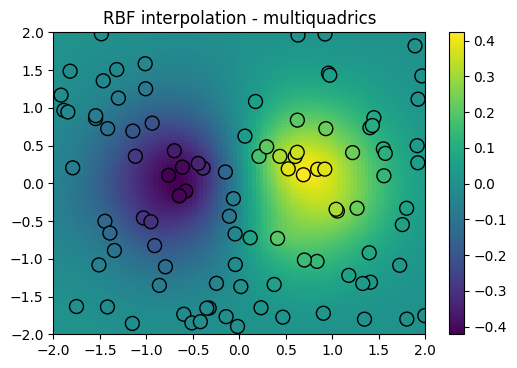

In [86]:
# 2-d tests - setup scattered data
x = np.random.rand(100)*4.0-2.0
y = np.random.rand(100)*4.0-2.0
z = x*np.exp(-x**2-y**2)
ti = np.linspace(-2.0, 2.0, 100)
XI, YI = np.meshgrid(ti, ti)

# use RBF
rbf = Rbf(x, y, z, epsilon=2, function='linear')
ZI = rbf(XI, YI)

# plot the result

plt.subplot(1, 1, 1)
plt.pcolor(XI, YI, ZI)
plt.scatter(x, y, 100, z, edgecolors='k')
plt.title('RBF interpolation - multiquadrics')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.colorbar()

In [87]:
x, y, z, d = np.random.rand(4, 50)
rbfi = Rbf(x, y, z, d)  # radial basis function interpolator instance
xi = yi = zi = np.linspace(0, 1, 20)
di = rbfi(xi, yi, zi)   # interpolated values
di.shape


(20,)

In [88]:
# anisotropy_function([2,4],[0,9])

In [89]:
points

array([[   0.25      ,    0.        ],
       [   0.5       ,    0.        ],
       [   1.        ,    0.        ],
       ..., 
       [   7.61577311, -156.80140949],
       [   8.60232527, -144.46232221],
       [   9.89949494, -135.        ]])

In [90]:


def tg43(radius, theta):
    initial_shape = np.shape(radius)
    radius_flat = np.ravel(radius)
    theta_flat = np.ravel(theta)
    
    geometry = normalised_geometry_function(length, radius_flat, theta_flat)
    radial_dose = radial_dose_function(radius_flat)
    anisotropy = anisotropy_function(radius_flat, theta_flat)
    
    result = dose_rate_constant * geometry * radial_dose * anisotropy
    
    
#     points = np.array([
#         [radius_flat[i], theta_flat[i]]
#         for i in np.where(~np.isnan(result))[0]])
#     values = result[~np.isnan(result)]   
    
#     interpolator = LinearNDInterpolator(
#         points, values, fill_value=np.nan)
    
#     result[radius_flat >= 4.9] = 0
#     result[np.isnan(result)] = interpolator(
#         radius_flat[np.isnan(result)], theta_flat[np.isnan(result)]
#     )
    
    result = np.reshape(result, initial_shape)
    
    return result

# Testing against provided D(x,y) table

From http://www.estro.org/binaries/content/assets/estro/about/gec-estro/tg43-sources/192ir-hdr_nucletron-mhdr-v2.xls

In [91]:
estro_x = np.array([
    0.00, 0.10, 0.15, 0.25, 0.35, 0.50, 0.75, 
    1.00, 1.50, 2.00, 2.50, 3.00, 5.00, 7.00])
estro_y = np.array([0])
estro_z = np.array([
    7.00, 6.00, 5.00, 4.00, 3.00, 2.50, 2.00, 1.50, 
    1.00, 0.75, 0.50, 0.25, 0.10, 0.00, -0.10, -0.25, 
    -0.50, -0.75, -1.00, -1.50, -2.00, -2.50, -3.00, 
    -4.00, -5.00, -6.00, -7.00])

estro_dose = np.swapaxes([[
    [0.0164, 0.0163, 0.0163, 0.0164, 0.0165, 0.0167, 0.0170, 0.0169, 0.0173, 0.0172, 0.0169, 0.0164, 0.0132, 0.0097],
    [0.0223, 0.0222, 0.0223, 0.0225, 0.0226, 0.023, 0.0234, 0.0233, 0.0238, 0.0236, 0.0228, 0.0219, 0.0165, 0.0116],
    [0.0318, 0.0319, 0.032, 0.0324, 0.0326, 0.0333, 0.034, 0.0341, 0.0345, 0.0336, 0.0319, 0.0299, 0.0208, 0.0137],
    [0.0483, 0.0486, 0.0488, 0.0496, 0.0502, 0.0524, 0.053, 0.0538, 0.0533, 0.0504, 0.0463, 0.0419, 0.0259, 0.0159],
    [0.0840, 0.0852, 0.0859, 0.0879, 0.0897, 0.0926, 0.0952, 0.095, 0.0899, 0.0803, 0.0698, 0.0598, 0.0319, 0.0182],
    [0.119, 0.122, 0.122, 0.127, 0.130, 0.134, 0.137, 0.134, 0.122, 0.104, 0.0864, 0.0713, 0.0349, 0.0192],
    [0.183, 0.190, 0.190, 0.198, 0.206, 0.212, 0.212, 0.201, 0.169, 0.135, 0.107, 0.0846, 0.0379, 0.0201],
    [0.324, 0.334, 0.343, 0.360, 0.372, 0.377, 0.358, 0.320, 0.239, 0.176, 0.130, 0.0985, 0.0406, 0.0209],
    [0.745, 0.781, 0.809, 0.849, 0.854, 0.810, 0.677, 0.540, 0.339, 0.223, 0.154, 0.112, 0.0427, 0.0215],
    [1.357, 1.440, 1.500, 1.539, 1.479, 1.301, 0.963, 0.701, 0.394, 0.246, 0.165, 0.117, 0.0435, 0.0217],
    [3.405, 3.631, 3.691, 3.408, 2.907, 2.185, 1.351, 0.884, 0.446, 0.265, 0.173, 0.121, 0.0441, 0.0219],
    [np.nan, 19.71, 15.12, 9.177, 5.968, 3.507, 1.760, 1.042, 0.483, 0.278, 0.178, 0.124, 0.0445, 0.0219],
    [np.nan, 58.79, 32.18, 14.19, 7.944, 4.154, 1.917, 1.096, 0.495, 0.282, 0.180, 0.125, 0.0446, 0.0220],
    [np.nan, 66.36, 36.36, 15.52, 8.434, 4.299, 1.950, 1.108, 0.497, 0.282, 0.180, 0.125, 0.0446, 0.0220],
    [np.nan, 58.79, 32.23, 14.20, 7.952, 4.151, 1.918, 1.097, 0.495, 0.282, 0.180, 0.125, 0.0446, 0.0220],
    [np.nan, 19.68, 15.14, 9.182, 5.976, 3.501, 1.761, 1.042, 0.483, 0.278, 0.178, 0.124, 0.0445, 0.0219],
    [3.127, 3.559, 3.655, 3.402, 2.909, 2.179, 1.350, 0.883, 0.446, 0.265, 0.173, 0.121, 0.0441, 0.0219],
    [1.242, 1.379, 1.467, 1.527, 1.476, 1.298, 0.963, 0.701, 0.394, 0.246, 0.165, 0.117, 0.0435, 0.0217],
    [0.668, 0.739, 0.783, 0.837, 0.848, 0.806, 0.677, 0.539, 0.339, 0.223, 0.154, 0.112, 0.0427, 0.0215],
    [0.301, 0.314, 0.327, 0.350, 0.366, 0.373, 0.357, 0.321, 0.240, 0.176, 0.130, 0.0987, 0.0406, 0.0209],
    [0.170, 0.179, 0.180, 0.190, 0.202, 0.210, 0.211, 0.200, 0.169, 0.135, 0.107, 0.0847, 0.0379, 0.0201],
    [0.112, 0.115, 0.115, 0.122, 0.127, 0.132, 0.136, 0.134, 0.121, 0.104, 0.0861, 0.0714, 0.0349, 0.0192],
    [0.0790, 0.0803, 0.0814, 0.0840, 0.0869, 0.0904, 0.094, 0.0943, 0.0896, 0.0802, 0.0695, 0.0597, 0.0319, 0.0182],
    [0.0455, 0.0470, 0.0466, 0.0473, 0.0494, 0.0509, 0.0528, 0.0532, 0.0529, 0.0502, 0.0461, 0.0418, 0.0259, 0.0159],
    [0.0303, 0.0305, 0.0307, 0.0311, 0.0316, 0.0322, 0.0333, 0.0334, 0.0342, 0.0344, 0.0318, 0.0298, 0.0207, 0.0137],
    [0.0212, 0.0213, 0.0214, 0.0216, 0.0219, 0.0222, 0.0228, 0.0229, 0.0236, 0.0234, 0.0228, 0.0217, 0.0165, 0.0116],
    [0.0156, 0.0156, 0.0157, 0.0158, 0.0160, 0.0162, 0.0165, 0.0166, 0.0171, 0.0171, 0.0168, 0.0163, 0.0132, 0.0097]]], 1,2)

np.shape(estro_dose)

(1, 14, 27)

C:\Users\sbiggs\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: RuntimeWarning: invalid value encountered in true_divide


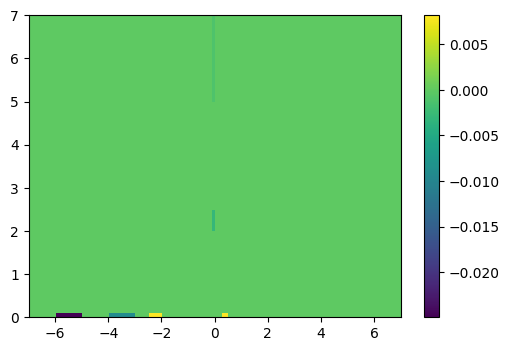

In [92]:
def calc_on_grid(x_mm, y_mm, z_mm, dwell_positions_mm, dwell_directions):
    xx_mm, yy_mm, zz_mm = np.meshgrid(x_mm, y_mm, z_mm)
    
    calc_grid_positions = np.array([
        [xx_mm.ravel()[i], yy_mm.ravel()[i], zz_mm.ravel()[i]]
        for i in range(len(xx_mm.ravel()))
    ])
    
    calc_grid_vector = calc_grid_positions[:,None,:] - dwell_positions_mm[None,:,:]
    
    radius_mm = np.sqrt(
        calc_grid_vector[:,:,0]**2 + 
        calc_grid_vector[:,:,1]**2 +
        calc_grid_vector[:,:,2]**2
    )
    
    radius_cm = radius_mm / 10
    
    calc_unit_vector = calc_grid_vector / radius_mm[:,:,None]
    dot_product = (
        dwell_directions[None,:,0] * calc_unit_vector[:,:,0] + 
        dwell_directions[None,:,1] * calc_unit_vector[:,:,1] + 
        dwell_directions[None,:,2] * calc_unit_vector[:,:,2]
    )
    
    theta = np.arccos(dot_product) * 180 / np.pi
    nan_ref = np.isnan(theta)
    equal_ref_initial = calc_unit_vector == dwell_directions
    equal_ref = np.all(equal_ref_initial, axis=2)
    theta[nan_ref & equal_ref] = 0
    theta[nan_ref & ~equal_ref] = 180
    
    tg43_dose = tg43(radius_cm, theta)
    
    return np.reshape(tg43_dose, (len(y_mm), len(x_mm), len(z_mm)))



estro_dwell_direction = np.array([[0, 0, 1]])
estro_dwell_position = np.array([[0, 0, 0]])

estro_calc_dose = calc_on_grid(
    estro_x*10, estro_y*10, estro_z*10, 
    estro_dwell_position, estro_dwell_direction)

relative = (estro_calc_dose - estro_dose)/estro_dose
relative[np.isnan(estro_dose)] = 0
plt.pcolor(estro_z, estro_x, relative[0,:,:])
plt.colorbar()


## Dose from all dwells

In [93]:
dose = load_dose_from_dicom(dcm_dose)
x_raw, y_raw, z_raw = load_xyz_from_dicom(dcm_dose)

calc_grid_slice_skip = 2

calc_grid_x = x_raw[::calc_grid_slice_skip]
calc_grid_y = y_raw[::calc_grid_slice_skip]
calc_grid_z = z_raw[::calc_grid_slice_skip]

dose_compare = dose[
    ::calc_grid_slice_skip,
    ::calc_grid_slice_skip,
    ::calc_grid_slice_skip
]

xx, yy, zz = np.meshgrid(
    calc_grid_x, calc_grid_y, calc_grid_z)
x = np.ravel(xx)
y = np.ravel(yy)
z = np.ravel(zz)

len(x)

122451

In [94]:
calc_grid_positions = np.array([
        [x[i], y[i], z[i]]
        for i in range(len(x))
])
np.shape(calc_grid_positions[:,None,:])

(122451, 1, 3)

In [95]:
np.shape(dwell_positions[None,:,:])

(1, 219, 3)

In [96]:
calc_grid_vector = calc_grid_positions[:,None,:] - dwell_positions[None,:,:]
np.shape(calc_grid_vector)

(122451, 219, 3)

In [97]:
radius_mm = np.sqrt(
    calc_grid_vector[:,:,0]**2 + 
    calc_grid_vector[:,:,1]**2 +
    calc_grid_vector[:,:,2]**2
)
radius = radius_mm / 10
np.shape(radius_mm)

(122451, 219)

In [98]:
calc_unit_vector = calc_grid_vector / radius_mm[:,:,None]
np.shape(calc_unit_vector)

(122451, 219, 3)

In [99]:
np.shape(dwell_directions[None,:,:])

(1, 219, 3)

In [100]:
dot_product = (
    dwell_directions[None,:,0] * calc_unit_vector[:,:,0] + 
    dwell_directions[None,:,1] * calc_unit_vector[:,:,1] + 
    dwell_directions[None,:,2] * calc_unit_vector[:,:,2]
)
np.shape(dot_product)

(122451, 219)

In [101]:
theta = np.arccos(dot_product) * 180 / np.pi
nan_ref = np.isnan(theta)
equal_ref_initial = calc_unit_vector == dwell_directions
equal_ref = np.all(equal_ref_initial, axis=2)
np.shape(equal_ref)

(122451, 219)

In [102]:
theta[nan_ref & equal_ref] = 0
theta[nan_ref & ~equal_ref] = 180

In [103]:
# ignore = np.any(radius < 1, axis=1)

In [104]:
tg43_dose = tg43(radius, theta)
np.shape(tg43_dose)

(122451, 219)

In [105]:
dwell_times

array([ 4.4441446 ,  3.53743926,  0.54528554,  0.83747958,  1.2643842 ,
        0.88938139,  0.6651014 ,  3.11030426,  0.14138572,  1.54951511,
        0.51383554,  0.22292494,  4.35958359,  1.43336884,  1.34698945,
        1.11360184,  1.18099274,  0.21455738,  0.58685331,  0.58776146,
        0.28970644,  0.8803372 ,  0.35951998,  0.36325476,  0.29862049,
        1.04852439,  0.38111431,  1.84388452,  1.71121972,  1.78205385,
        0.22289336,  0.59284031,  0.74100127,  0.51868456,  0.81555428,
        0.29663733,  1.26089843,  0.29709725,  0.22349213,  1.04000355,
        1.63372315,  1.97241404,  1.11680094,  0.44608613,  0.74063572,
        0.36930412,  1.48212317,  1.85360843,  1.14979274,  0.59440003,
        1.18886752,  0.67172401,  0.30406326,  2.78795872,  1.39861483,
        0.66215803,  0.        ,  0.05953608,  0.16012504,  0.23015739,
        0.17933705,  0.0966381 ,  0.        ,  0.        ,  0.22002774,
        0.62648276,  1.36702671,  1.84216005,  3.03128169,  1.81

In [106]:
total_dose = np.sum(tg43_dose*(ref_airkerma_rate / 60 / 60 / 100) * dwell_times[None, :], axis=1)
# total_dose[ignore] = np.nan

total_dose = np.reshape(total_dose, (len(calc_grid_y), len(calc_grid_x), len(calc_grid_z)))
np.shape(total_dose)

(51, 49, 49)

In [107]:
max_out_dose_val = np.max(dose_compare)
total_dose[total_dose > max_out_dose_val] = max_out_dose_val

In [108]:
diff = dose_compare - total_dose
diff = diff[~np.isnan(diff)]
print("median = {}, mean = {}, std = {}".format(np.median(diff), np.mean(diff), np.std(diff)))

median = 0.0020754185251572466, mean = 0.017668082932610085, std = 0.28116409889065563


In [109]:
ratio = total_dose/dose_compare
ratio = ratio[~np.isnan(ratio)]
print("median = {}, mean = {}, std = {}".format(np.median(ratio), np.mean(ratio), np.std(ratio)))

median = 0.9983819981794166, mean = 0.9990100446519843, std = 0.011929044941513482


# Plot percent deviation between dose grids

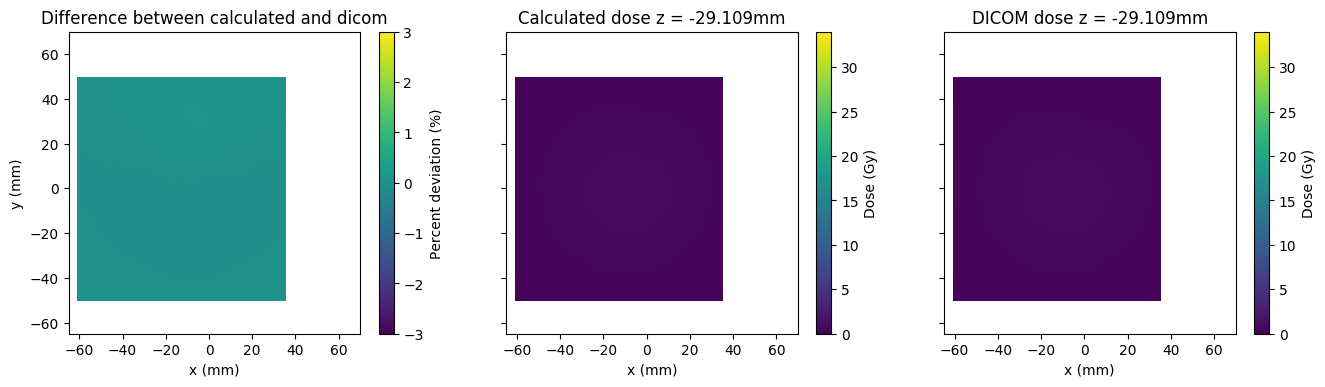

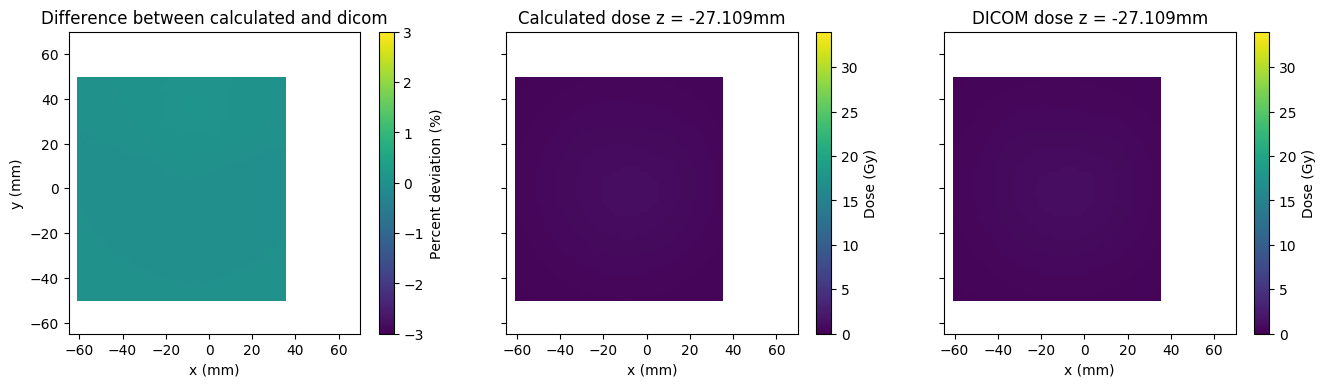

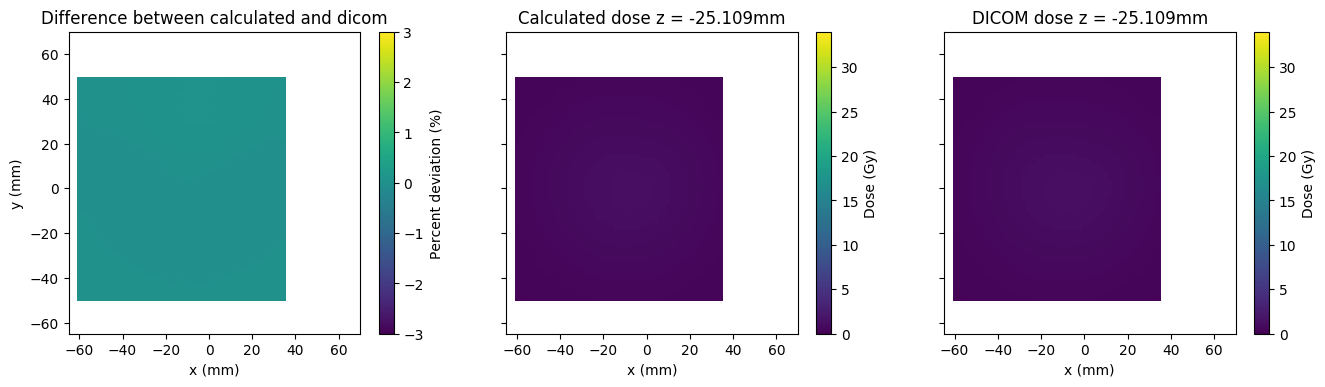

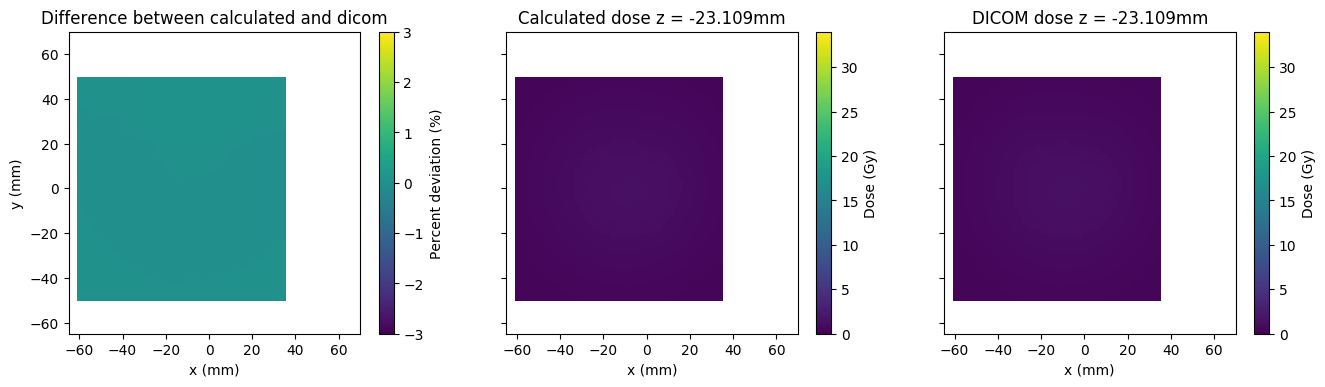

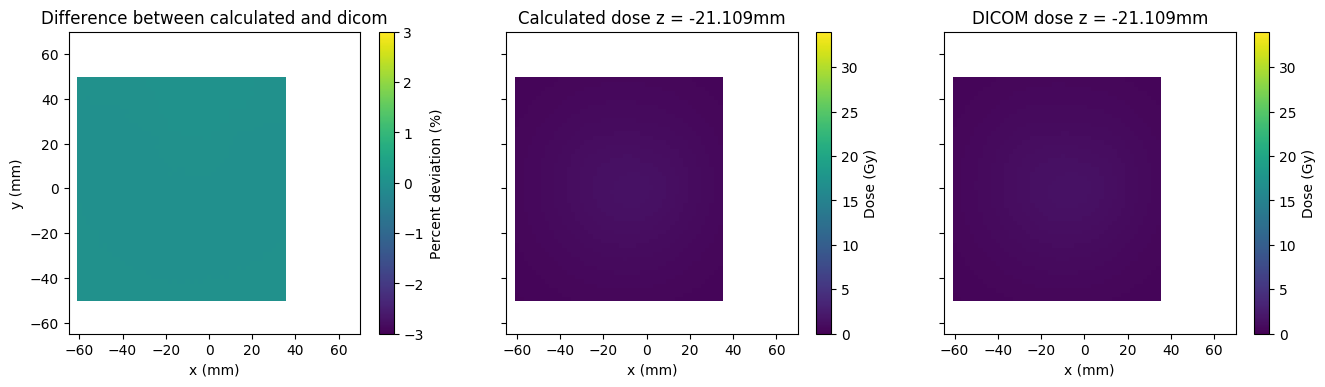

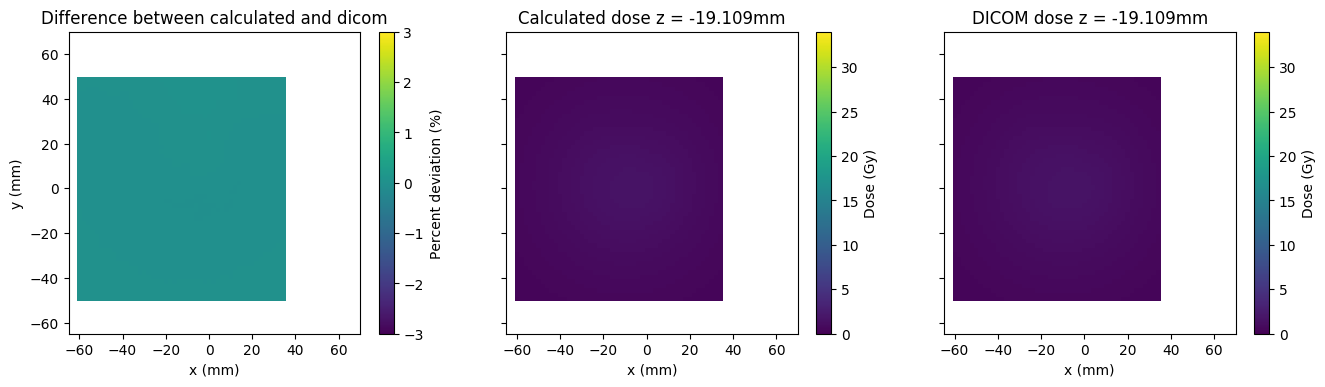

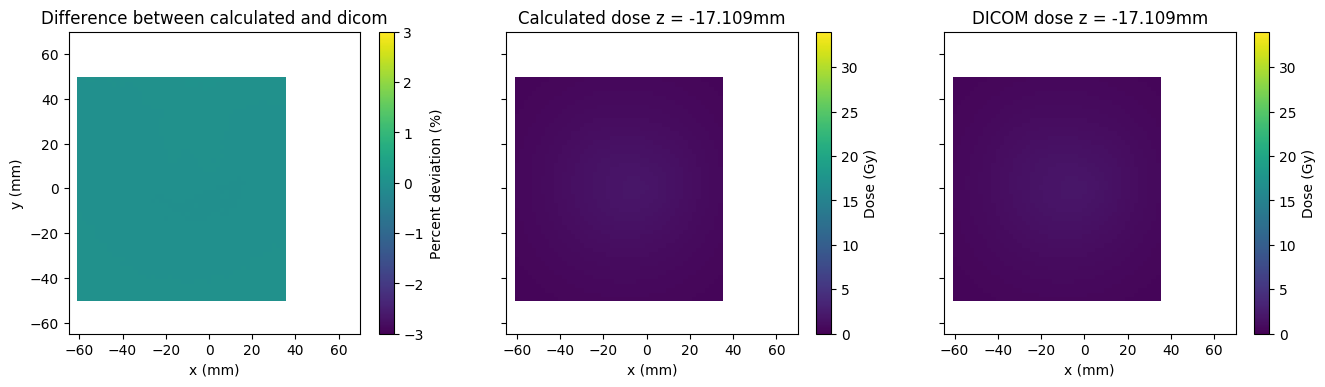

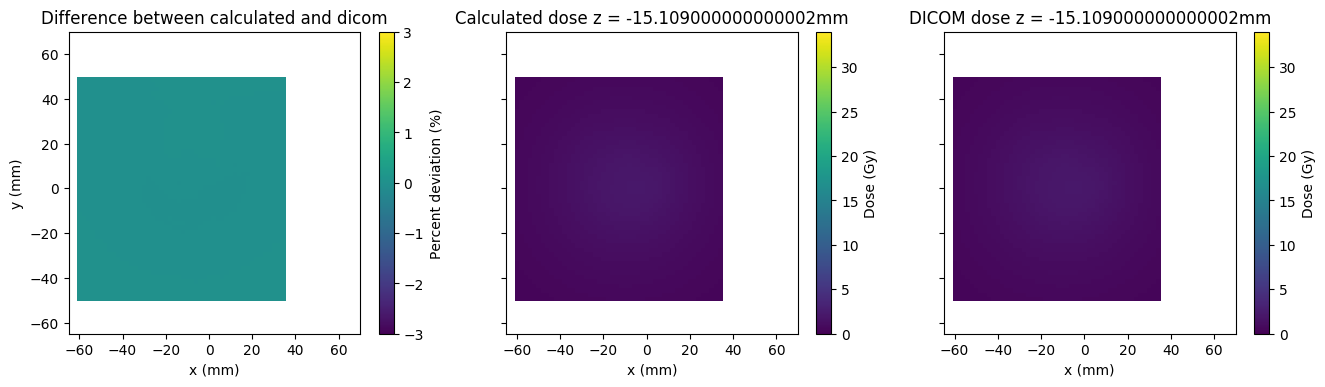

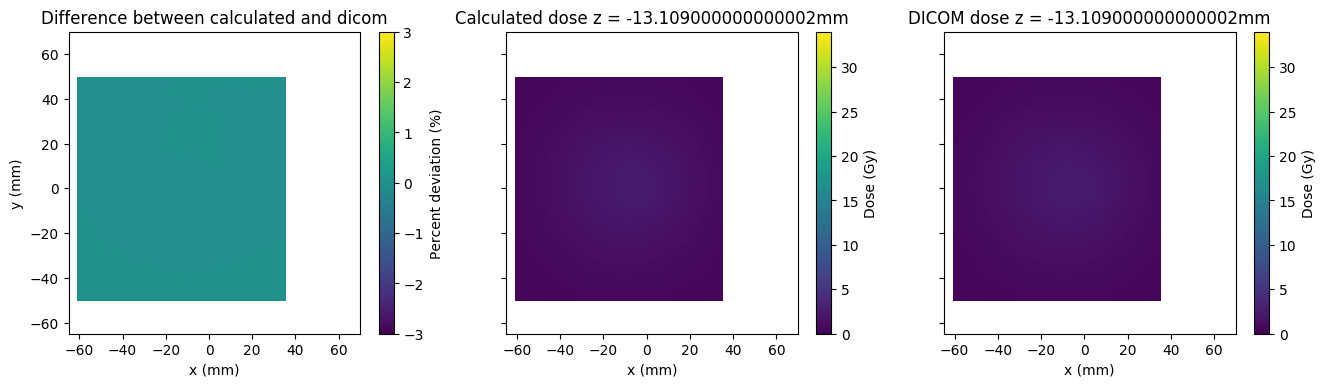

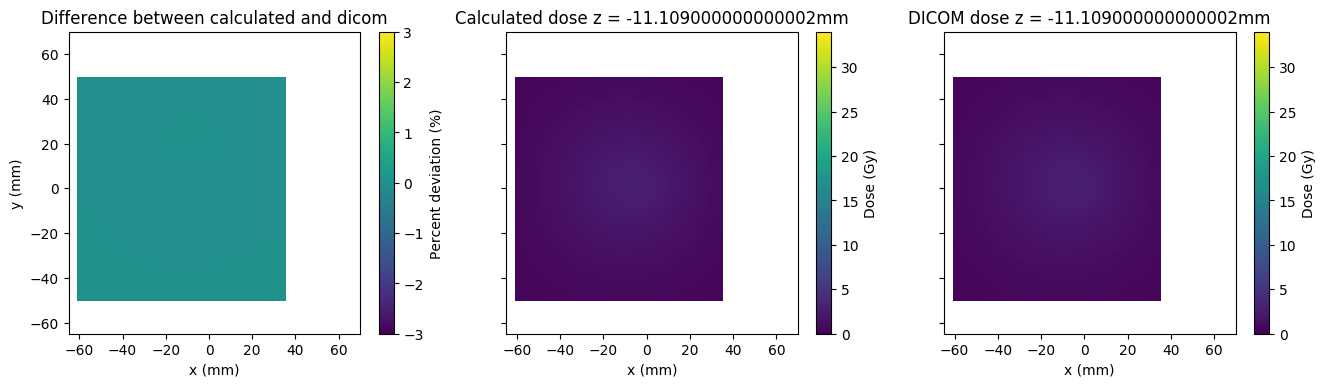

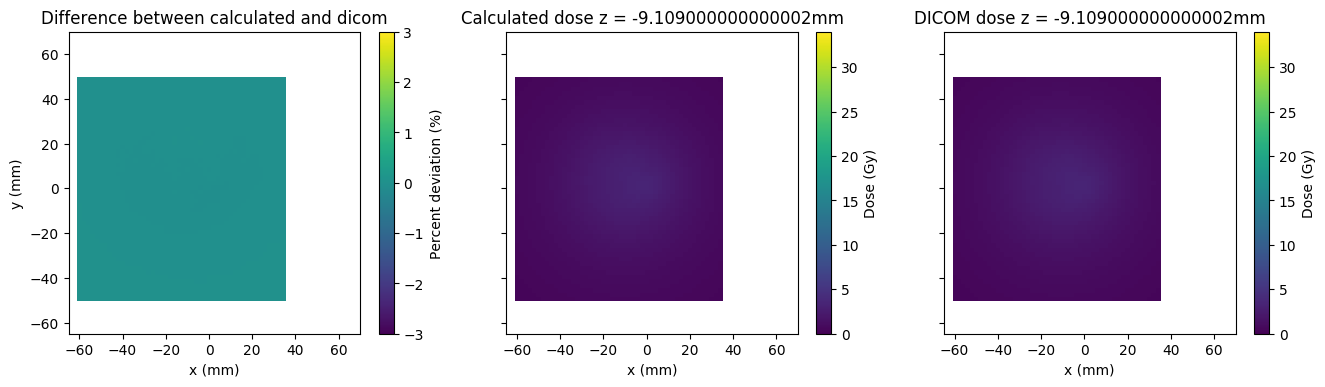

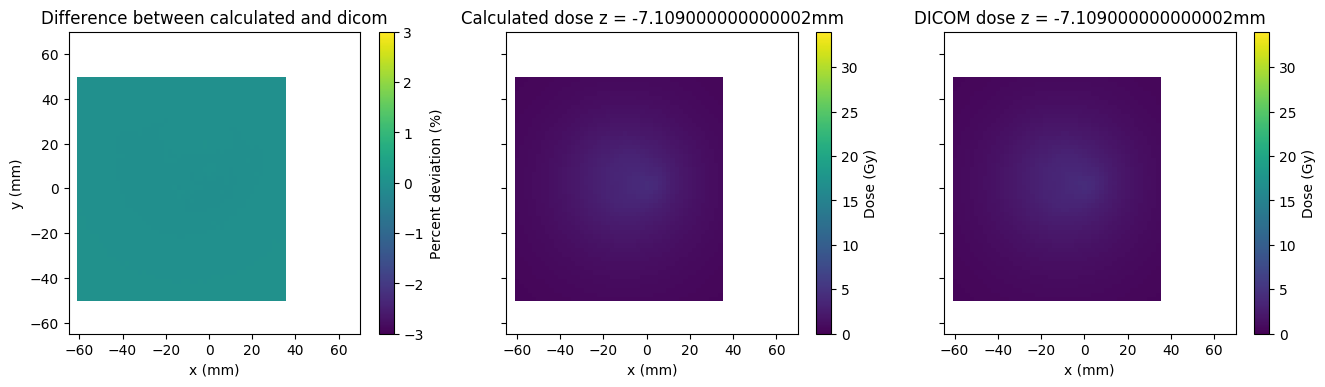

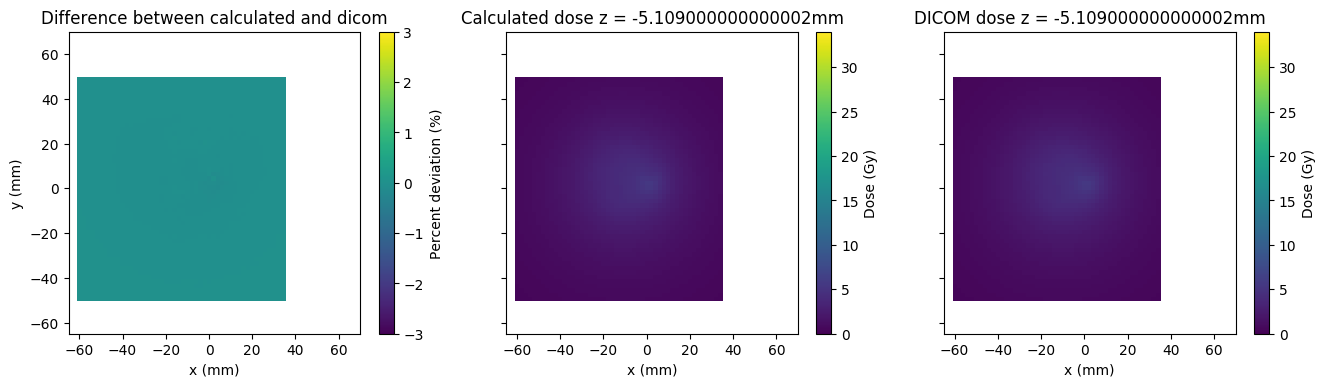

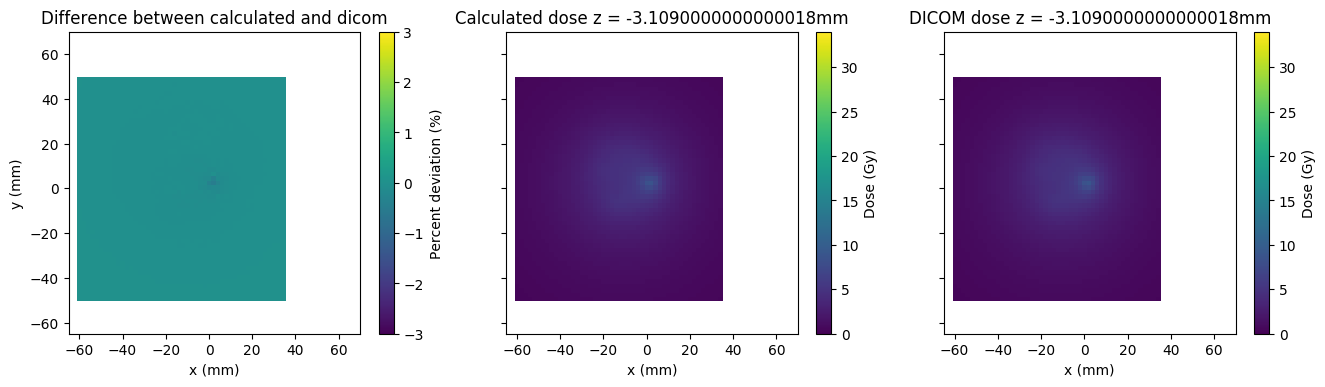

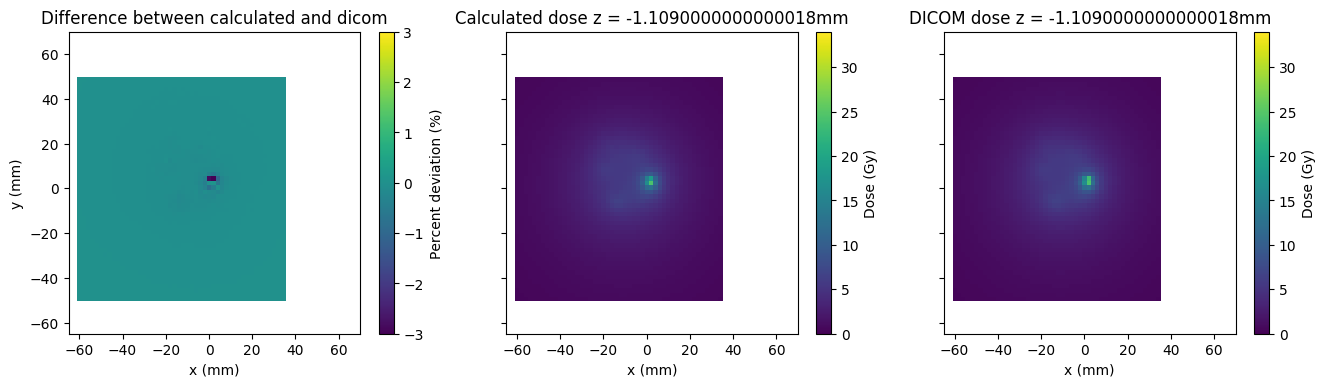

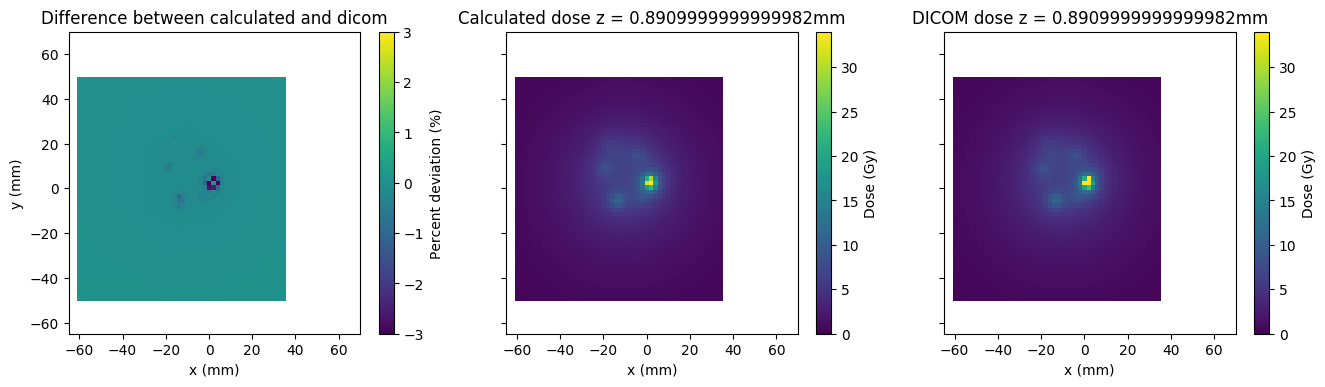

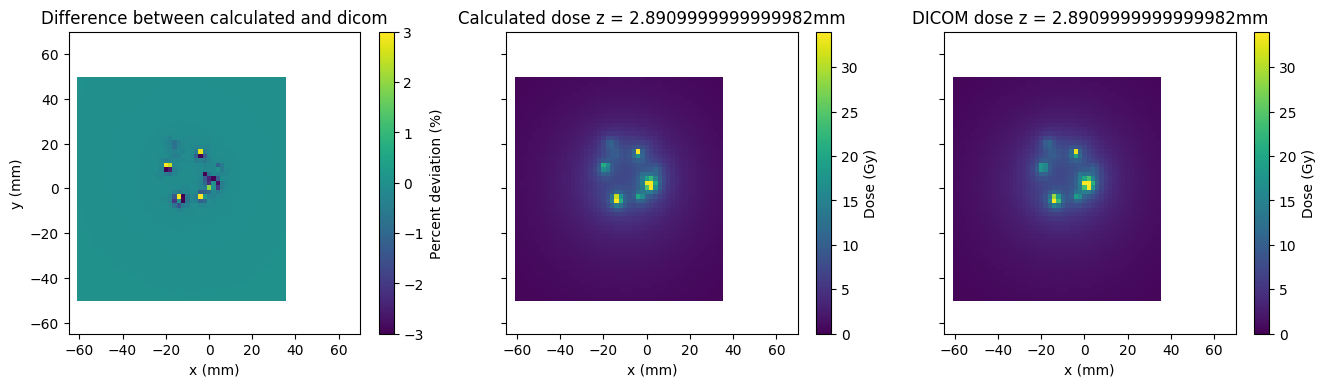

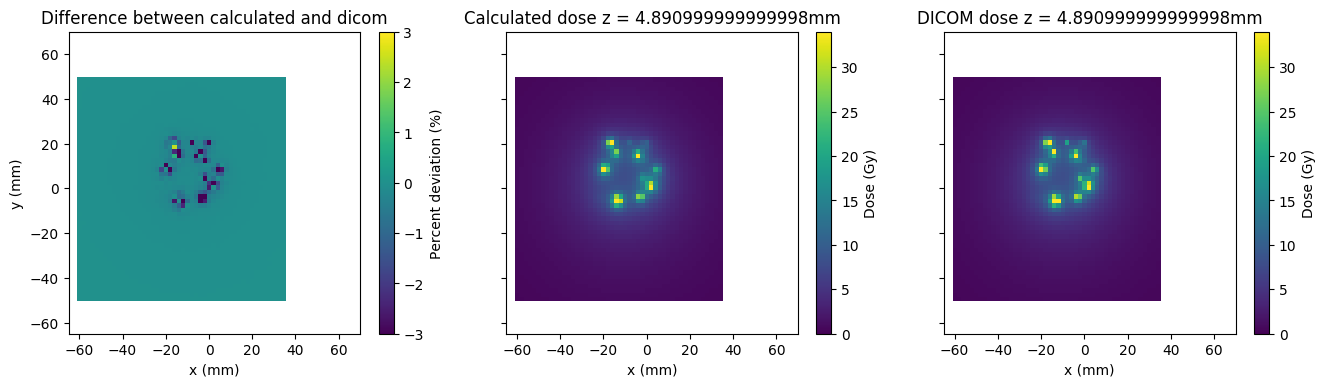

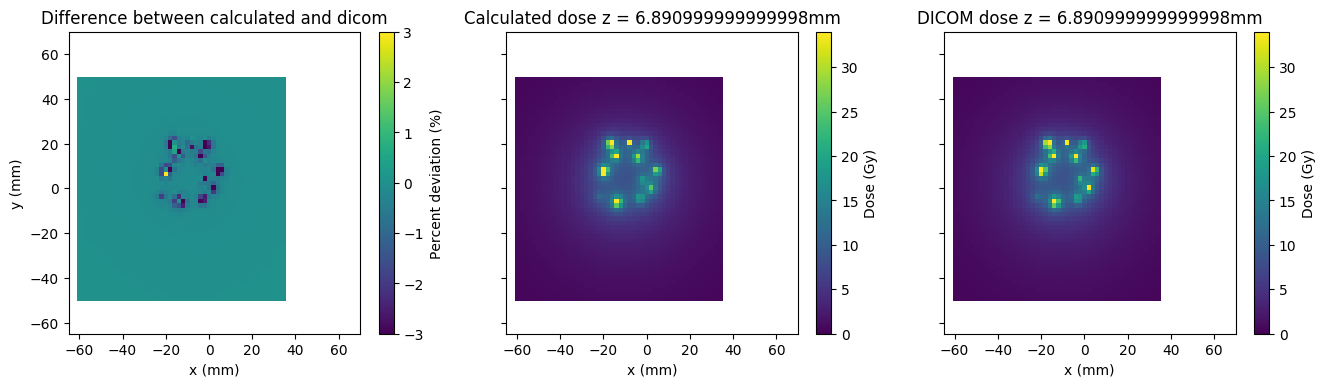

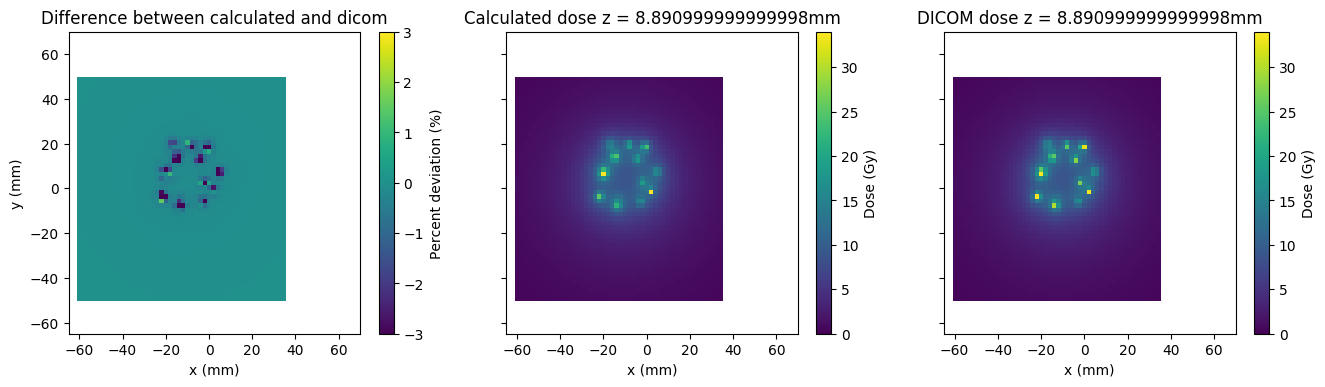

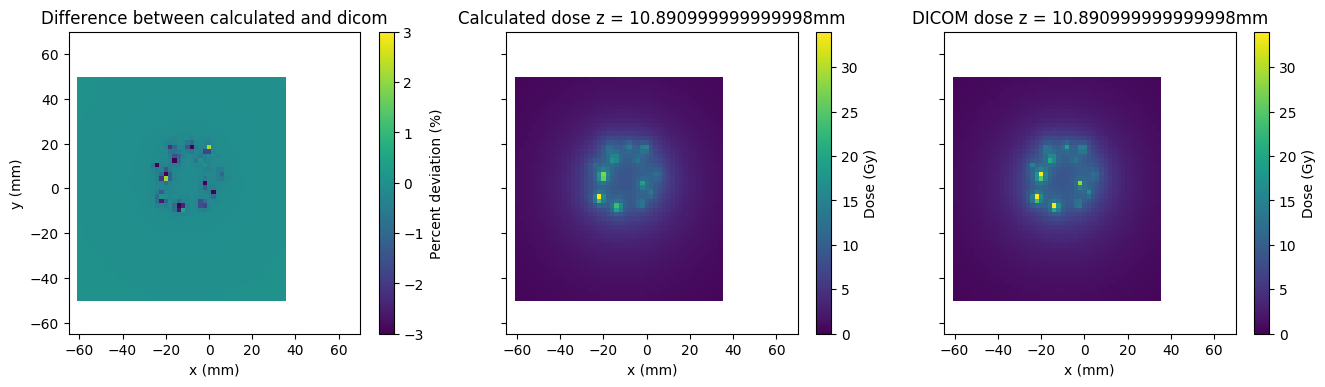

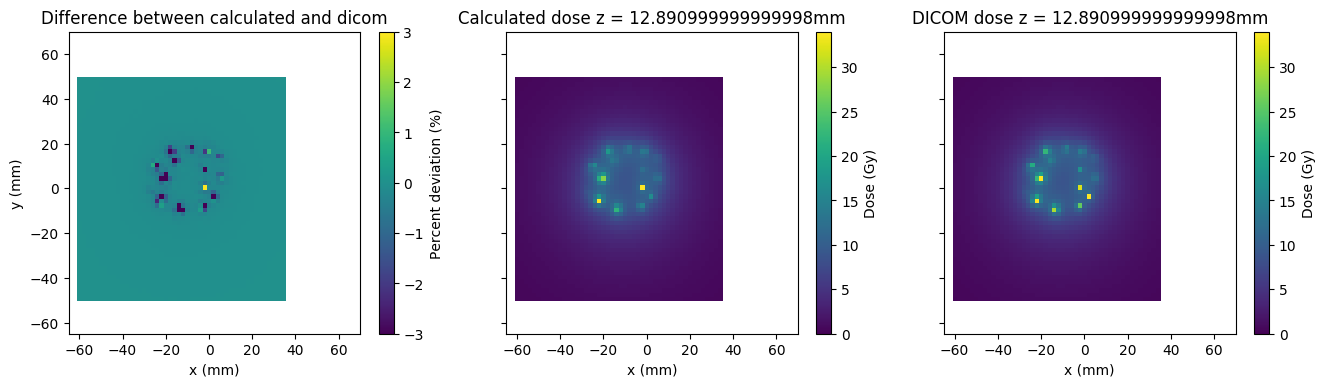

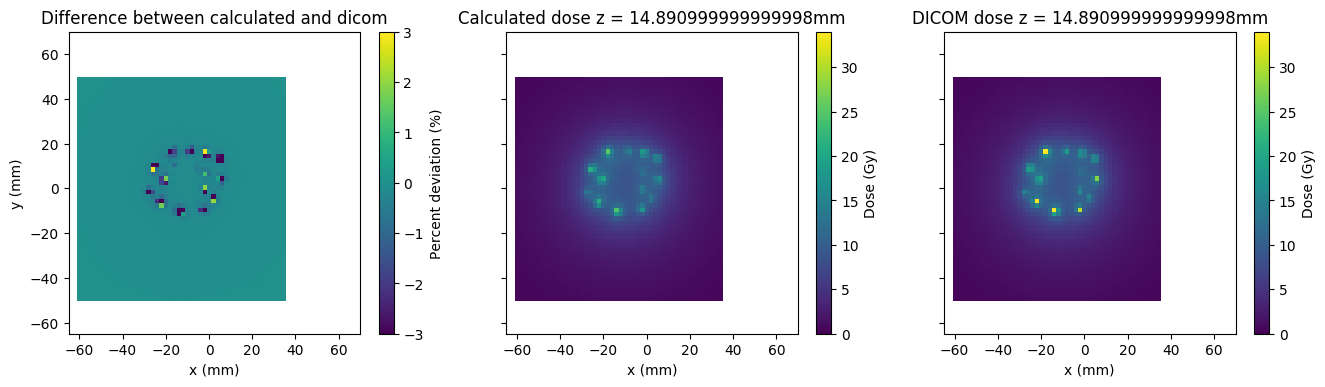

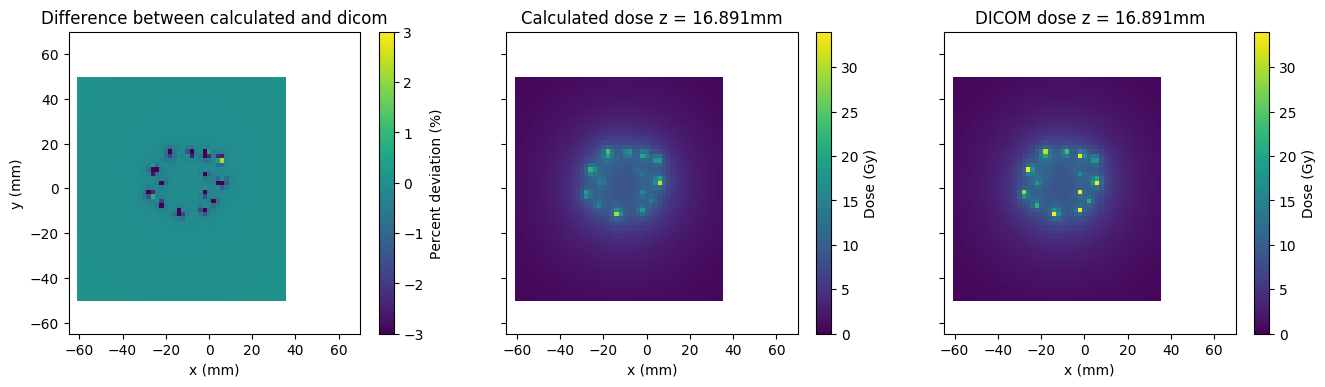

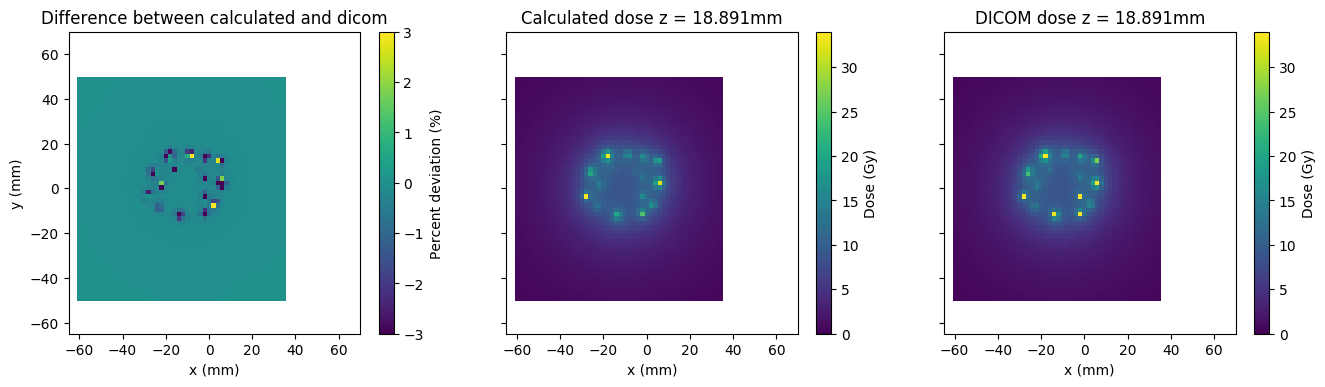

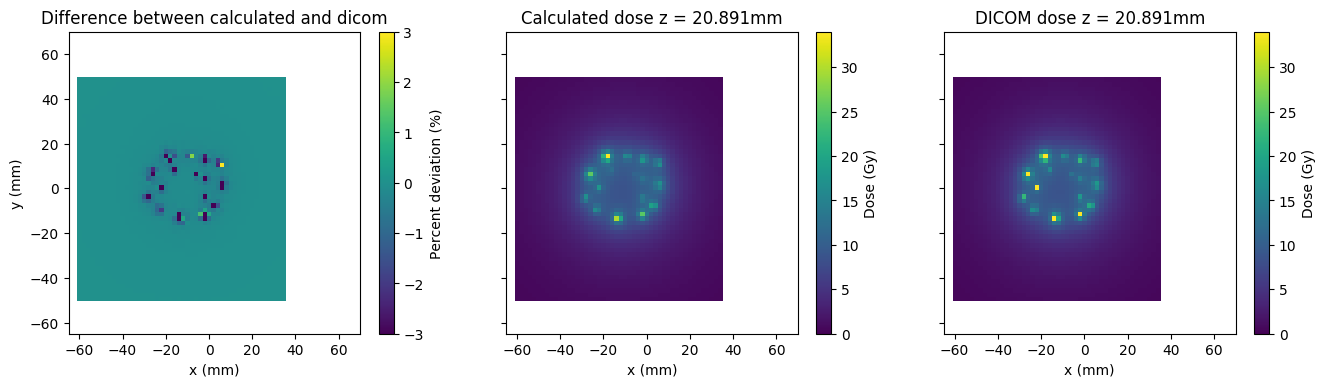

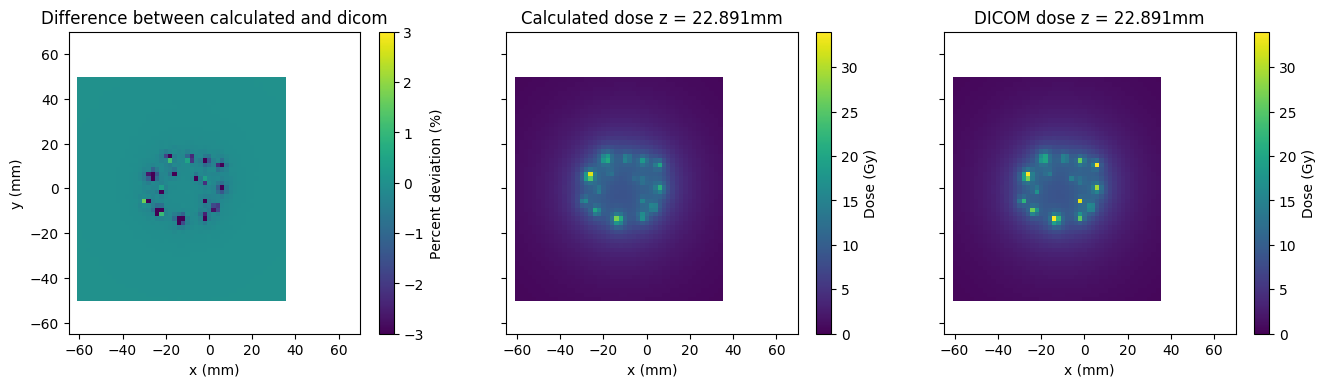

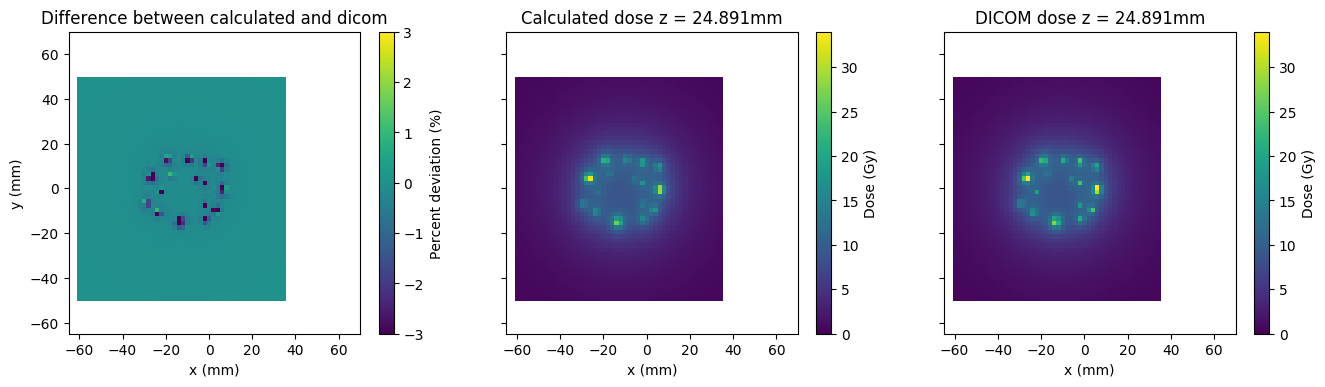

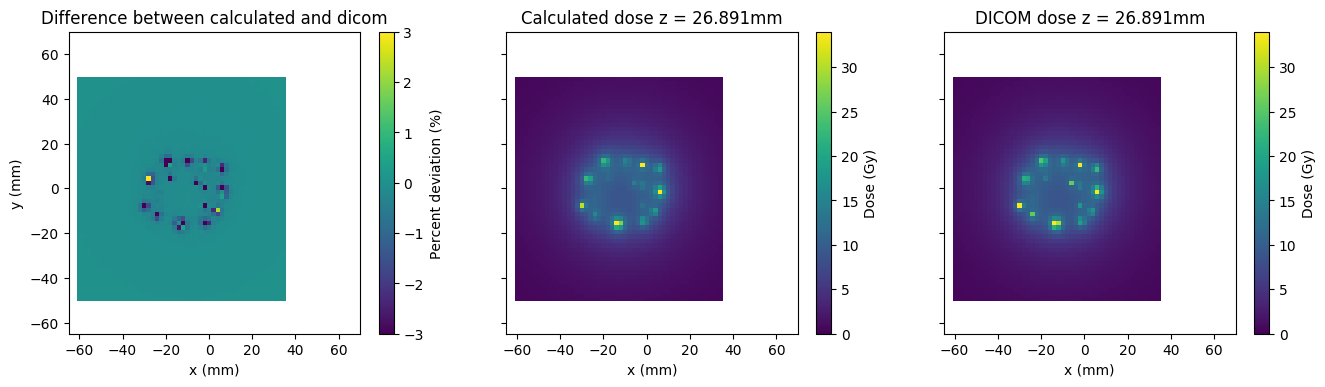

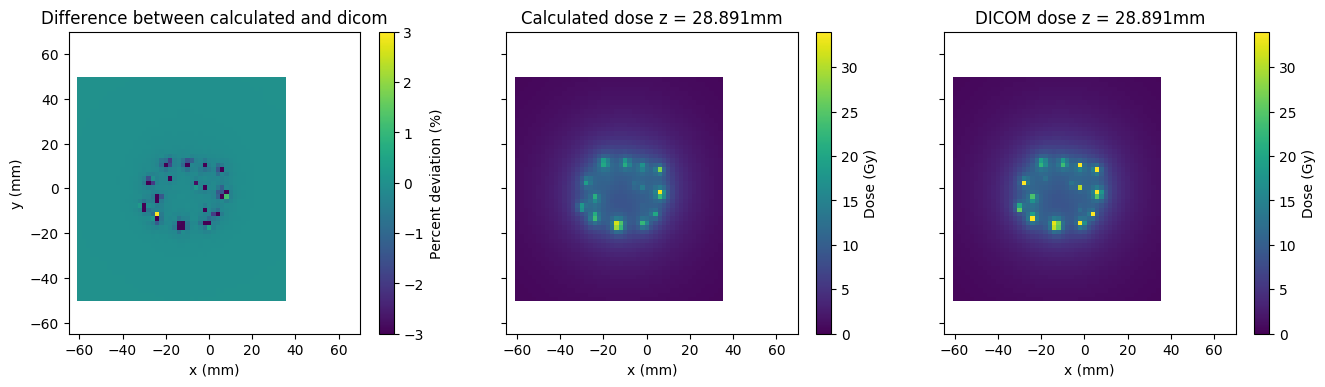

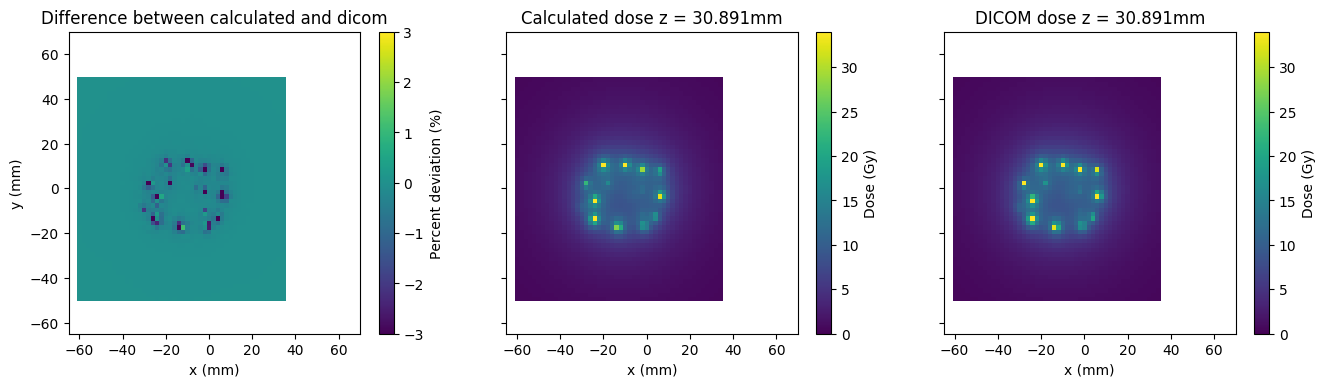

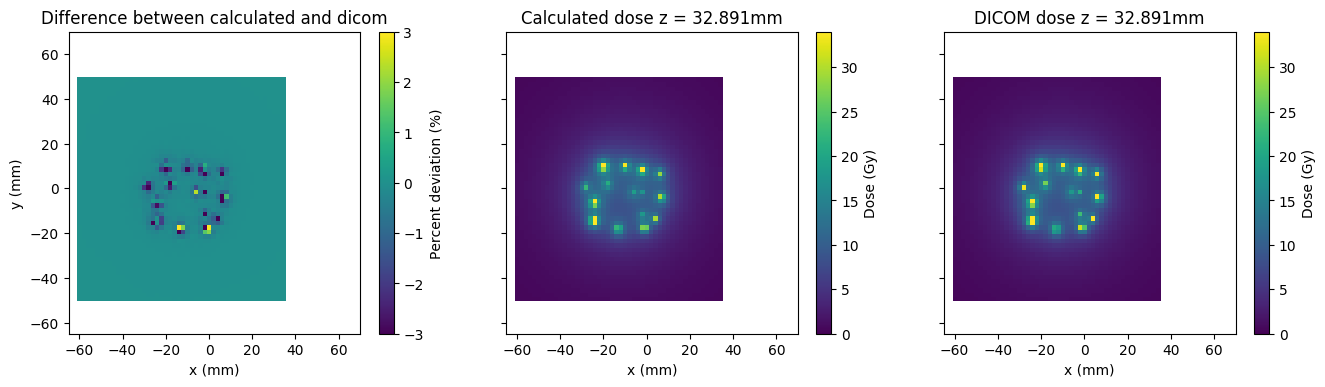

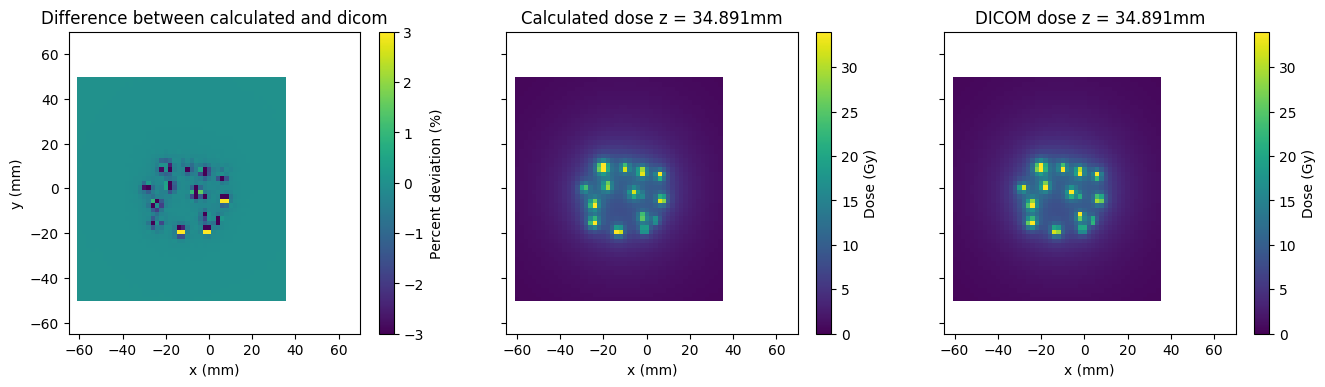

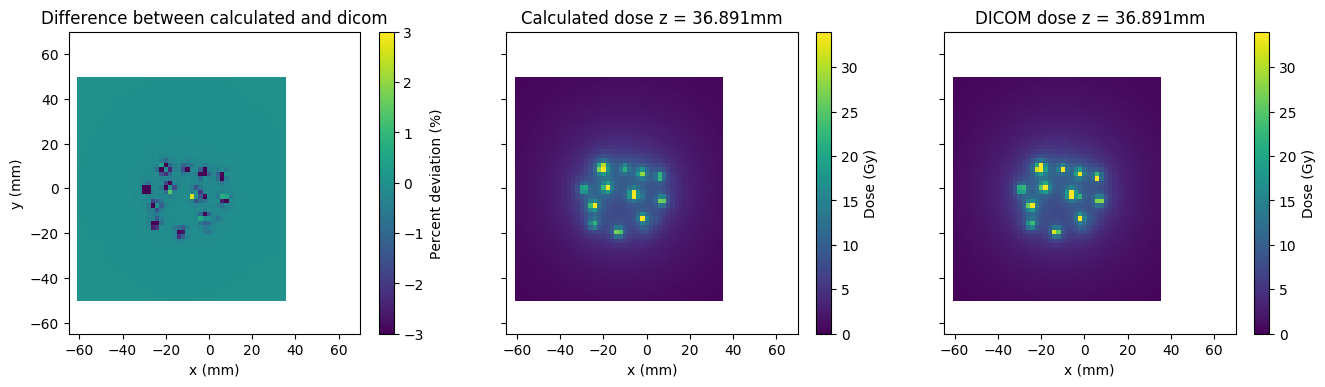

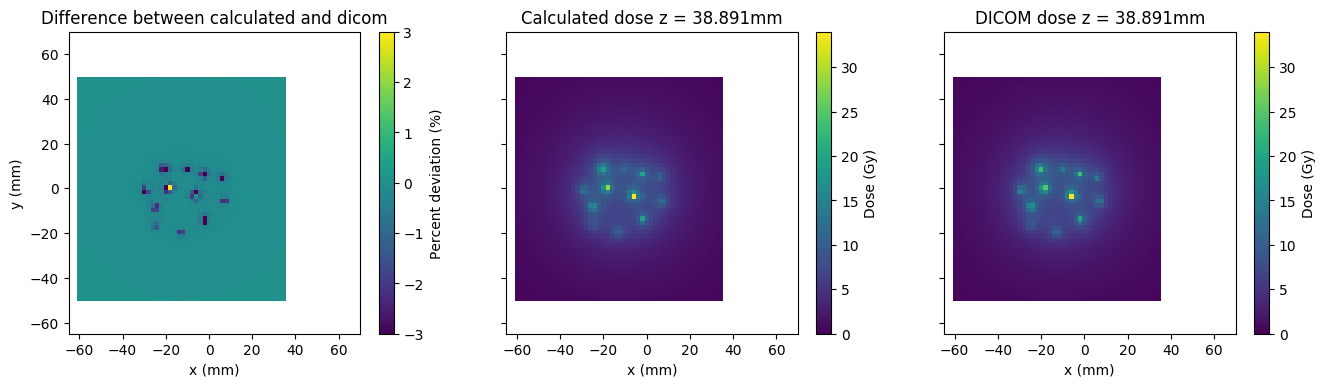

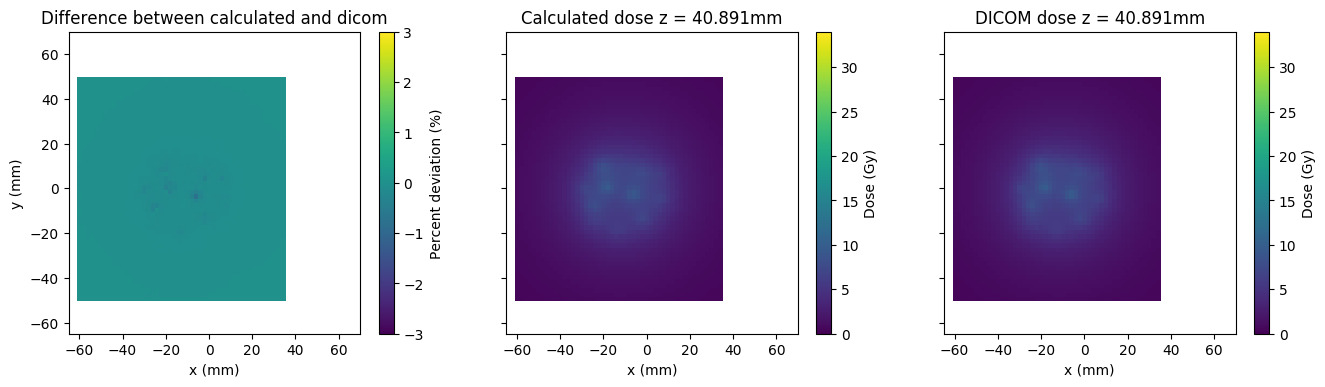

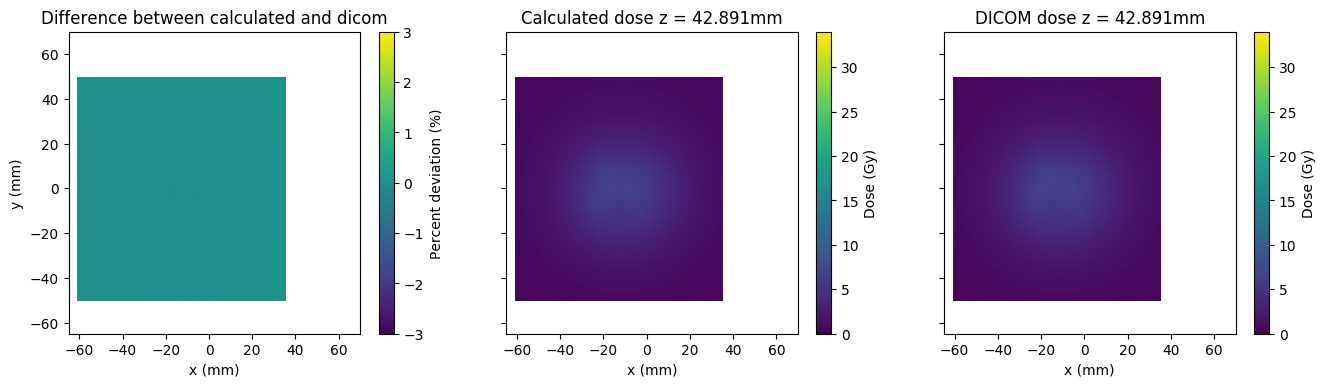

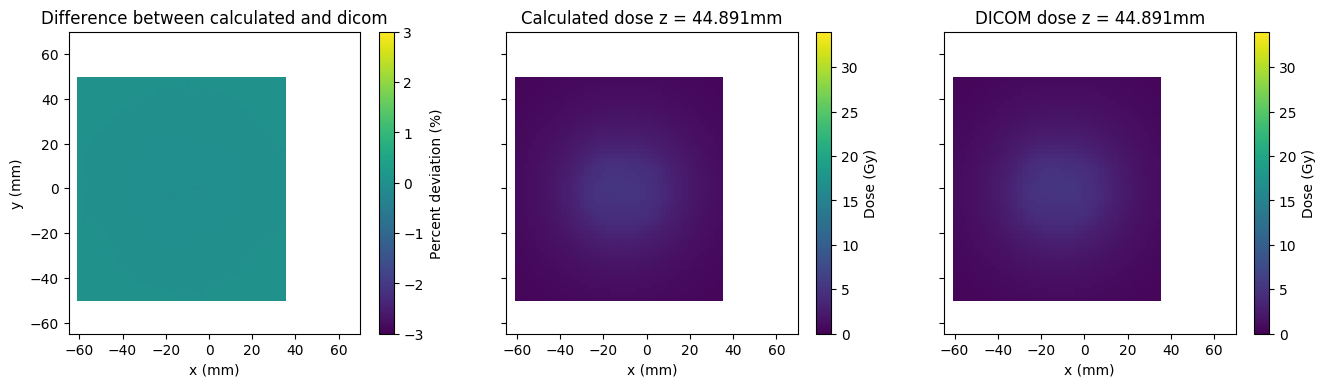

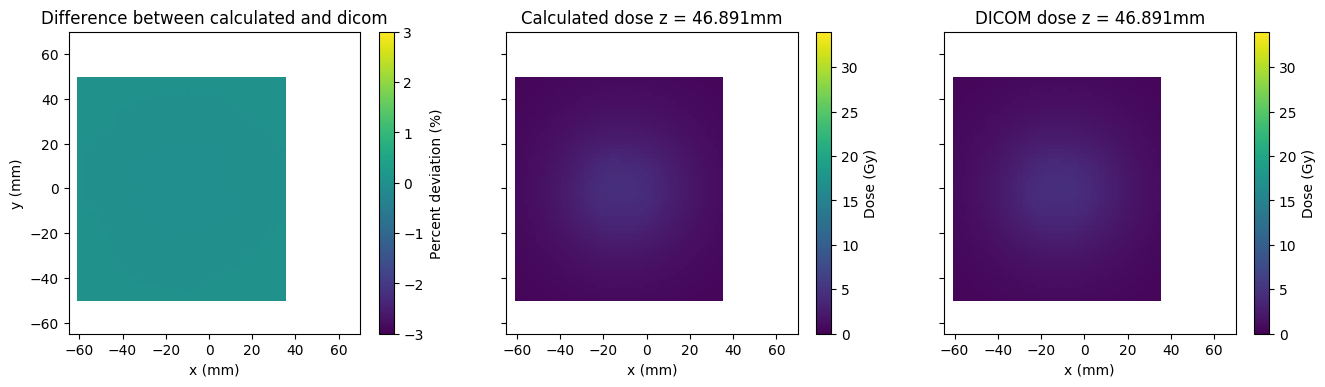

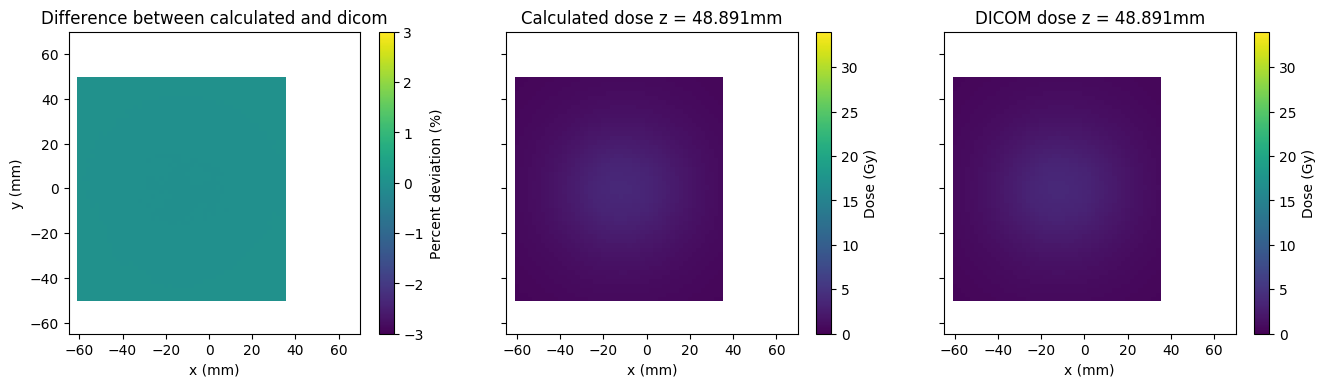

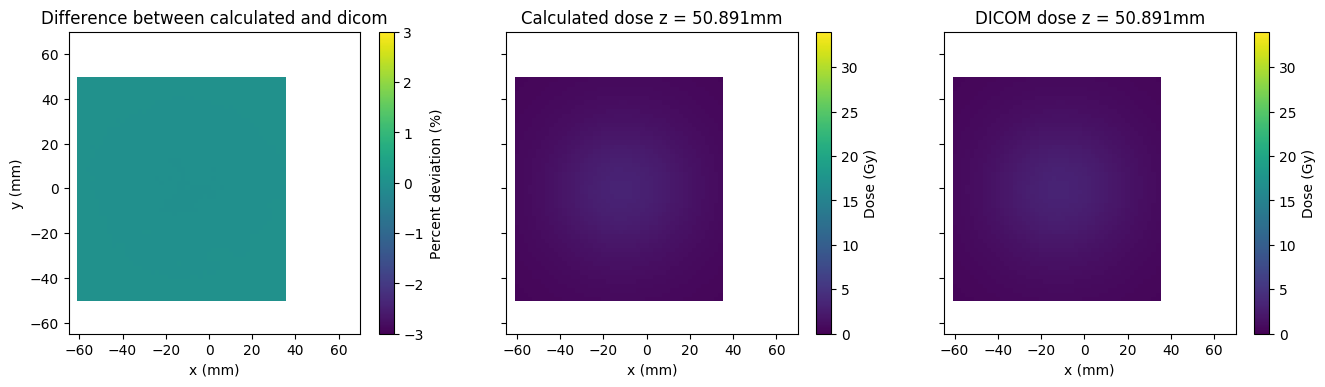

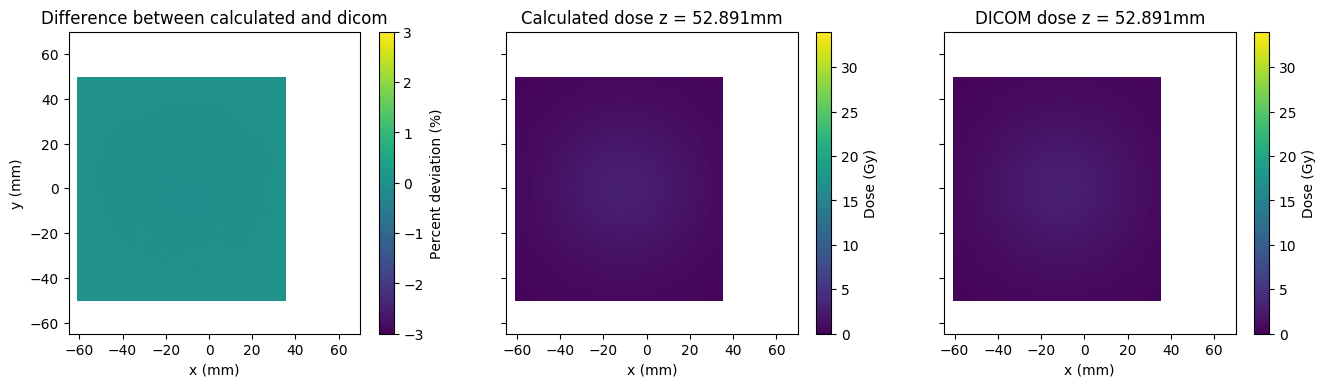

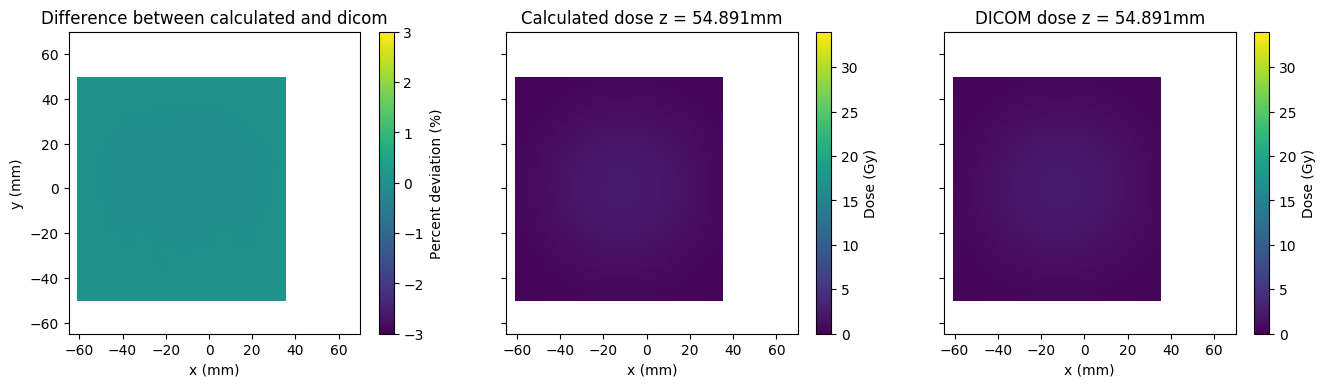

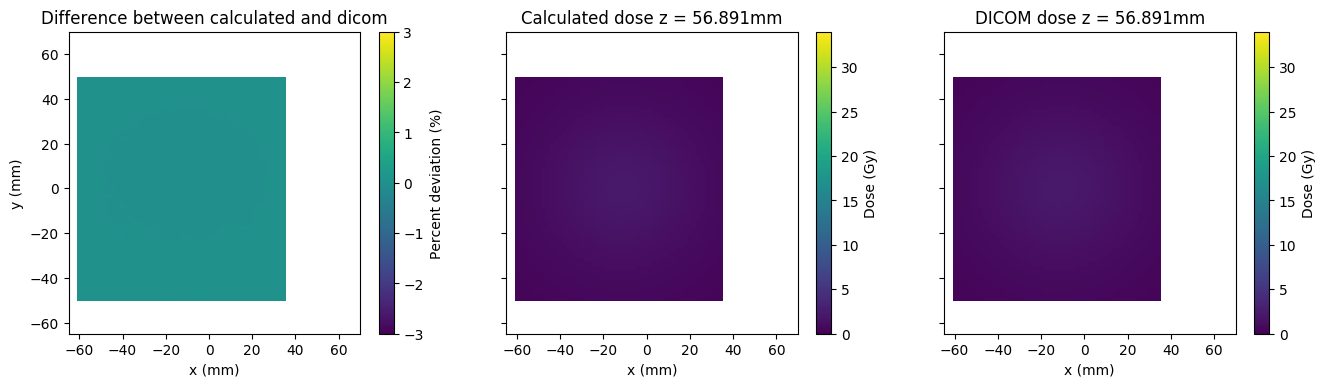

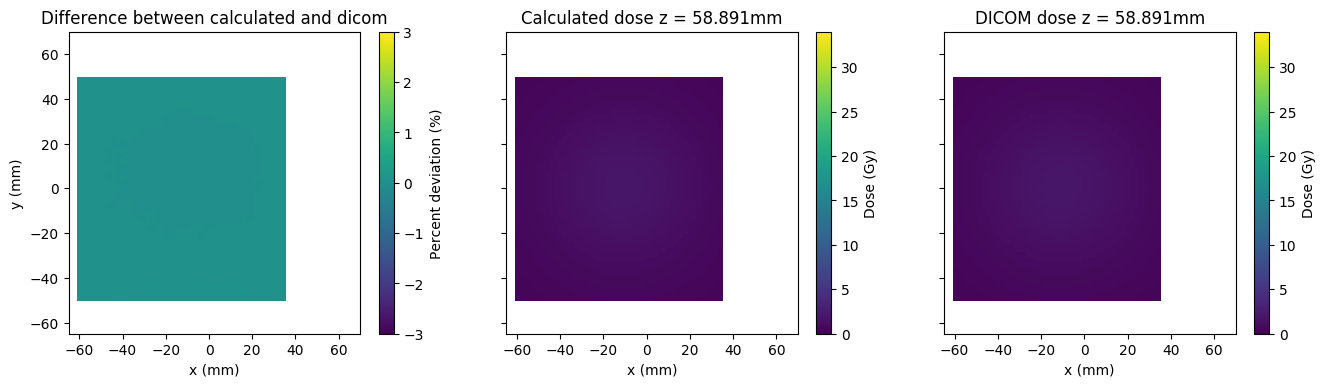

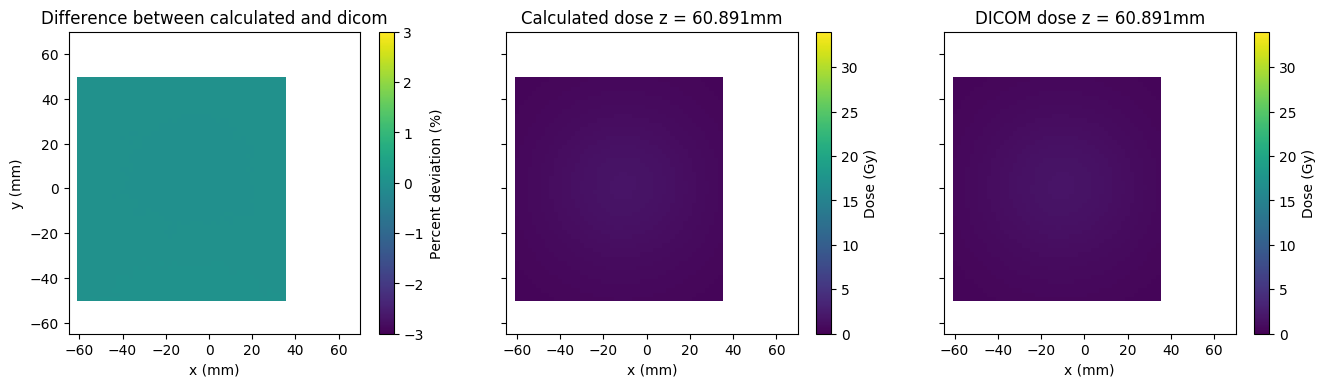

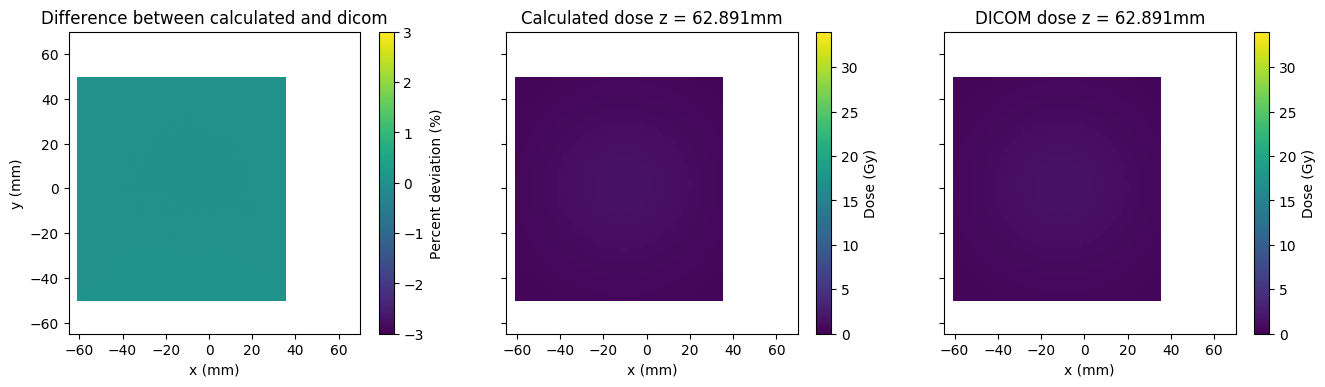

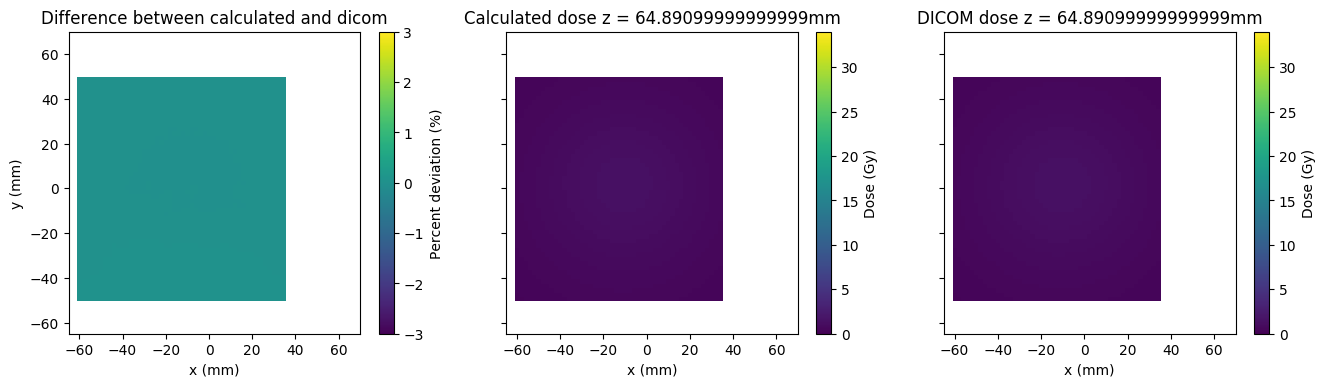

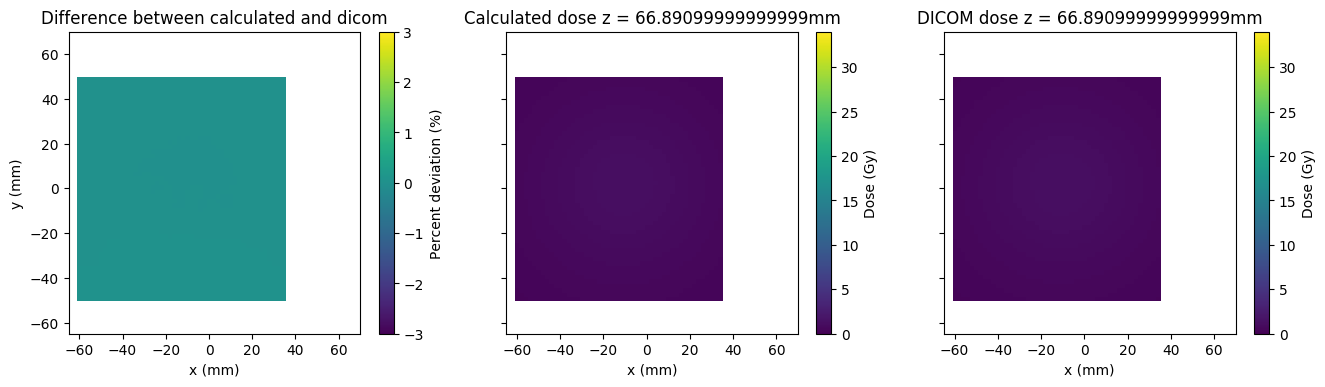

In [110]:
bound = 3

for i in np.arange(len(calc_grid_z)):
    dose_print = 100 * (total_dose[:, :, i] - dose_compare[:, :, i]) / max_out_dose_val
    dose_print[dose_print > bound] = bound
    dose_print[dose_print < -bound] = -bound
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16,4))
    
    c1 = ax1.pcolor(
        calc_grid_x, calc_grid_y, dose_print, 
        vmin=-bound, vmax=bound, cmap='viridis')
    ax1.set_title("Difference between calculated and dicom")
    ax1.set_ylabel("y (mm)")
    ax1.set_xlabel("x (mm)")
    
    cbar = plt.colorbar(c1, ax=ax1)
    cbar.ax.set_ylabel('Percent deviation (%)')    
    
    ax1.set_xlim([-65,70])
    ax1.set_ylim([-65,70])
    
    c2 = ax2.pcolor(
        calc_grid_x, calc_grid_y, total_dose[:, :, i], 
        vmin=0, vmax=np.max(total_dose), cmap='viridis')
    ax2.set_title("Calculated dose z = {}mm".format(calc_grid_z[i]))
    ax2.set_xlabel("x (mm)")
    cbar = plt.colorbar(c2, ax=ax2)
    cbar.ax.set_ylabel('Dose (Gy)')    
    ax2.set_xlim([-65,70])
    ax2.set_ylim([-65,70])
    
    
    c3 = ax3.pcolor(
        calc_grid_x, calc_grid_y, dose_compare[:, :, i], 
        vmin=0, vmax=max_out_dose_val, cmap='viridis')
    ax3.set_title("DICOM dose z = {}mm".format(calc_grid_z[i]))
    ax3.set_xlabel("x (mm)")
    cbar = plt.colorbar(c3, ax=ax3)
    cbar.ax.set_ylabel('Dose (Gy)')    
    ax3.set_xlim([-65,70])
    ax3.set_ylim([-65,70])    
    
    plt.show()